In [ ]:
!pip  install kaggle

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d adarshrouniyar/air-pollution-image-dataset-from-india-and-nepal

 98% 594M/606M [00:07<00:00, 58.2MB/s]
100% 606M/606M [00:07<00:00, 86.7MB/s]


In [ ]:
! unzip /content/air-pollution-image-dataset-from-india-and-nepal.zip

Streaming output truncated to the last 5000 lines.
  inflating: Air Pollution Image Dataset/Air Pollution Image Dataset/Country_wise_Dataset/India/Mumbai/c_Unhealthy_for_Sensitive_Groups/MH_UnFSG_2023-03-18-11.00-1-127.jpg  
  inflating: Air Pollution Image Dataset/Air Pollution Image Dataset/Country_wise_Dataset/India/Mumbai/c_Unhealthy_for_Sensitive_Groups/MH_UnFSG_2023-03-18-11.00-1-134.jpg  
  inflating: Air Pollution Image Dataset/Air Pollution Image Dataset/Country_wise_Dataset/India/Mumbai/c_Unhealthy_for_Sensitive_Groups/MH_UnFSG_2023-03-18-11.00-1-141.jpg  
  inflating: Air Pollution Image Dataset/Air Pollution Image Dataset/Country_wise_Dataset/India/Mumbai/c_Unhealthy_for_Sensitive_Groups/MH_UnFSG_2023-03-18-11.00-1-148.jpg  
  inflating: Air Pollution Image Dataset/Air Pollution Image Dataset/Country_wise_Dataset/India/Mumbai/c_Unhealthy_for_Sensitive_Groups/MH_UnFSG_2023-03-18-11.00-1-15.jpg  
  inflating: Air Pollution Image Dataset/Air Pollution Image Dataset/Country_wis

# Air Pollution Notebook


In [1]:
import sys
import numpy as np
import pandas as pd

from typing import Dict, Optional, Tuple
from pathlib import Path

import math

import tensorflow as tf
from tensorflow import keras

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.preprocessing import LabelEncoder

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.inception_v3 import InceptionV3

from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Concatenate, LeakyReLU, Input, Conv2D, MaxPooling2D
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing import image

from sklearn.metrics import r2_score
from sklearn.utils import shuffle

%matplotlib inline

In [2]:
train = pd.read_csv('/content/Dataset_for_AQI_Classification/Dataset_for_AQI_Classification/train_data.csv')

train.head()

,Location,Filename,Year,Month,Day,Hour,AQI,PM2.5,PM10,O3,CO,SO2,NO2,AQI_Class
0,Tamil Nadu,TN_UnFSG_2023-03-02-08.30-1.jpg,2023,3,2,8:30,119,69.00,106.00,8.00,358.00,22.0,26.00,c_Unhealthy_for_Sensitive_Groups
1,Bengaluru,BENGR_Mod_2023-02-24-08.30-1-166.jpg,2023,2,24,8:30,68,32.00,61.00,26.00,228.00,5.0,21.00,b_Moderate
2,"Biratnagar, Nepal",BIR_UNFSG_VF_2023-02-03-15.00-2-24.jpg,2023,2,3,15:00,141,47.96,68.92,65.57,0.41,2.8,2.51,c_Unhealthy_for_Sensitive_Groups
3,Mumbai,MH_UnFSG_2023-03-10-16.00-1-76.jpg,2023,3,10,16:00,141,72.00,108.00,NaN,NaN,NaN,63.00,c_Unhealthy_for_Sensitive_Groups
4,"ITO, Delhi",DEL_SEV_2023-02-07-14.00-2-8.jpg,2023,2,7,14:00,449,337.00,198.00,23.00,24.00,13.0,57.00,f_Severe


In [3]:
test = pd.read_csv('/content/Dataset_for_AQI_Classification/Dataset_for_AQI_Classification/testing_data.csv')

test.head()

,Location,Filename,Year,Month,Day,Hour,AQI,PM2.5,PM10,O3,CO,SO2,NO2,AQI_Class
0,"Biratnagar, Nepal",BRI_Un_2023-02-02- 12.00-9.jpg,2023,2,2,12:00,158,70.08,100.82,58.89,0.49,4.4,1.04,d_Unhealthy
1,"Biratnagar, Nepal",BIR_UNH_VF_2023-02-02- 12.00-3-72.jpg,2023,2,2,12:00,158,70.08,100.82,58.89,0.49,4.4,1.04,d_Unhealthy
2,"Biratnagar, Nepal",BIR_UNH_VF_2023-02-02- 12.00-3-71.jpg,2023,2,2,12:00,158,70.08,100.82,58.89,0.49,4.4,1.04,d_Unhealthy
3,"Biratnagar, Nepal",BIR_UNH_VF_2023-02-02- 12.00-3-65.jpg,2023,2,2,12:00,158,70.08,100.82,58.89,0.49,4.4,1.04,d_Unhealthy
4,"Biratnagar, Nepal",BIR_UNH_VF_2023-02-02- 12.00-3-56.jpg,2023,2,2,12:00,158,70.08,100.82,58.89,0.49,4.4,1.04,d_Unhealthy


In [4]:
val = pd.read_csv('/content/Dataset_for_AQI_Classification/Dataset_for_AQI_Classification/val_data.csv')

val.head()

,Location,Filename,Year,Month,Day,Hour,AQI,PM2.5,PM10,O3,CO,SO2,NO2,AQI_Class
0,Bengaluru,BENGR_Mod_2023-02-23-08.30-1-401.jpg,2023,2,23,8:30,97,43.0,78.0,26.0,258.0,10.0,17.0,b_Moderate
1,"ITO, Delhi",DEL_SEV_2023-02-22-14.00-2-221.jpg,2023,2,22,14:00,450,500.0,480.0,91.0,78.0,17.0,47.0,f_Severe
2,"New Ind Town, Faridabad",HAR_VUN_2022-10-02-10.00-1-2361.jpg,2022,10,2,10:00,230,185.0,199.0,10.0,52.0,12.0,26.0,e_Very_Unhealthy
3,"ITO, Delhi",DEL_VUnH_2023-02-16-14.00-2-7.jpg,2023,2,16,14:00,268,401.0,325.0,73.0,88.0,16.0,NaN,e_Very_Unhealthy
4,Mumbai,MH_Good_2023-03-23-17.00-2.jpg,2023,3,23,17:00,47,14.0,41.0,35.0,6.0,5.0,7.0,a_Good


In [5]:
print("Train Set Shape : ", train.shape)
print("Test Set Shape : ", test.shape)
print("Validation Set  Shape : ", val.shape)

Train Set Shape :  (7833, 14)
Test Set Shape :  (2448, 14)
Validation Set  Shape :  (1959, 14)


In [6]:
train.describe()

,Year,Month,Day,AQI,PM2.5,PM10,O3,CO,SO2,NO2
count,7833.000000,7833.000000,7833.000000,7833.000000,7833.000000,7833.000000,7646.000000,7476.000000,6897.000000,7560.000000
mean,2022.948806,2.675731,12.088600,167.496362,142.615333,145.115133,39.362828,101.013596,13.328538,37.936238
std,0.220407,1.756803,8.288886,102.446227,130.099442,103.524800,33.048123,115.947148,9.912162,39.728267
min,2022.000000,2.000000,1.000000,15.000000,4.000000,7.000000,1.000000,0.000000,2.000000,0.670000
25%,2023.000000,2.000000,3.000000,97.000000,35.000000,68.920000,12.000000,4.000000,4.400000,7.000000
50%,2023.000000,2.000000,13.000000,152.000000,70.080000,113.000000,31.000000,52.000000,10.000000,20.000000
75%,2023.000000,3.000000,20.000000,230.000000,257.000000,198.000000,59.660000,174.000000,20.000000,64.000000
max,2023.000000,10.000000,28.000000,450.000000,500.000000,480.000000,225.000000,410.000000,57.000000,169.000000


In [7]:
val.describe()

,Year,Month,Day,AQI,PM2.5,PM10,O3,CO,SO2,NO2
count,1959.000000,1959.000000,1959.000000,1959.000000,1959.000000,1959.000000,1906.000000,1851.000000,1722.000000,1882.000000
mean,2022.944359,2.696784,12.130168,168.307810,143.661965,147.124354,40.029250,100.492636,12.870685,37.623496
std,0.229285,1.824514,8.241435,103.122297,132.913107,107.615319,33.184663,113.987242,9.663351,39.218161
min,2022.000000,2.000000,1.000000,15.000000,4.000000,7.000000,1.000000,0.000000,2.000000,0.670000
25%,2023.000000,2.000000,3.000000,97.000000,35.000000,64.000000,13.000000,3.000000,4.400000,6.490000
50%,2023.000000,2.000000,13.000000,152.000000,70.080000,111.000000,31.000000,52.000000,10.000000,20.000000
75%,2023.000000,3.000000,20.000000,230.000000,257.000000,198.000000,59.660000,174.000000,19.000000,63.000000
max,2023.000000,10.000000,28.000000,450.000000,500.000000,480.000000,225.000000,410.000000,48.000000,169.000000


In [8]:
test.describe()

,Year,Month,Day,AQI,PM2.5,PM10,O3,CO,SO2,NO2
count,2448.000000,2448.000000,2448.000000,2448.000000,2448.000000,2448.000000,2385.000000,2331.000000,2137.000000,2360.000000
mean,2022.946487,2.710376,12.205882,167.586601,143.990294,146.327418,39.491140,102.691364,13.229331,37.782970
std,0.225100,1.789911,8.241706,103.940184,131.371700,105.327161,34.396107,117.632656,9.760349,39.310508
min,2022.000000,2.000000,1.000000,15.000000,4.000000,7.000000,1.000000,0.000000,2.000000,0.670000
25%,2023.000000,2.000000,3.000000,97.000000,35.000000,64.000000,12.000000,5.000000,4.400000,7.000000
50%,2023.000000,2.000000,13.000000,152.000000,70.080000,113.000000,27.000000,52.000000,10.000000,21.000000
75%,2023.000000,3.000000,19.000000,230.000000,257.000000,198.000000,59.660000,175.000000,20.000000,63.000000
max,2023.000000,10.000000,28.000000,450.000000,500.000000,480.000000,225.000000,410.000000,48.000000,169.000000


In [9]:
print("Train Set Shape : \n", train.isna().sum())
print("\nTest Set Shape : \n", test.isna().sum())
print("\nValidation Set  Shape : \n", val.isna().sum())

Train Set Shape : 
 Location       0
Filename       0
Year           0
Month          0
Day            0
Hour           0
AQI            0
PM2.5          0
PM10           0
O3           187
CO           357
SO2          936
NO2          273
AQI_Class      0
dtype: int64

Test Set Shape : 
 Location       0
Filename       0
Year           0
Month          0
Day            0
Hour           0
AQI            0
PM2.5          0
PM10           0
O3            63
CO           117
SO2          311
NO2           88
AQI_Class      0
dtype: int64

Validation Set  Shape : 
 Location       0
Filename       0
Year           0
Month          0
Day            0
Hour           0
AQI            0
PM2.5          0
PM10           0
O3            53
CO           108
SO2          237
NO2           77
AQI_Class      0
dtype: int64


In [10]:
train = train.drop(columns =['O3', 'CO', 'SO2', 'NO2'] , axis=1 )
test = test.drop(columns =['O3', 'CO', 'SO2', 'NO2'] , axis=1 )
val = val.drop(columns =['O3', 'CO', 'SO2', 'NO2'] , axis=1 )

In [11]:
print("Train Set Shape : \n", train.isna().sum())
print("\nTest Set Shape : \n", test.isna().sum())
print("\nValidation Set  Shape : \n", val.isna().sum())

Train Set Shape : 
 Location     0
Filename     0
Year         0
Month        0
Day          0
Hour         0
AQI          0
PM2.5        0
PM10         0
AQI_Class    0
dtype: int64

Test Set Shape : 
 Location     0
Filename     0
Year         0
Month        0
Day          0
Hour         0
AQI          0
PM2.5        0
PM10         0
AQI_Class    0
dtype: int64

Validation Set  Shape : 
 Location     0
Filename     0
Year         0
Month        0
Day          0
Hour         0
AQI          0
PM2.5        0
PM10         0
AQI_Class    0
dtype: int64


In [12]:
print("Train Set Shape : ", train.shape)
print("Test Set Shape : ", test.shape)
print("Validation Set  Shape : ", val.shape)

Train Set Shape :  (7833, 10)
Test Set Shape :  (2448, 10)
Validation Set  Shape :  (1959, 10)


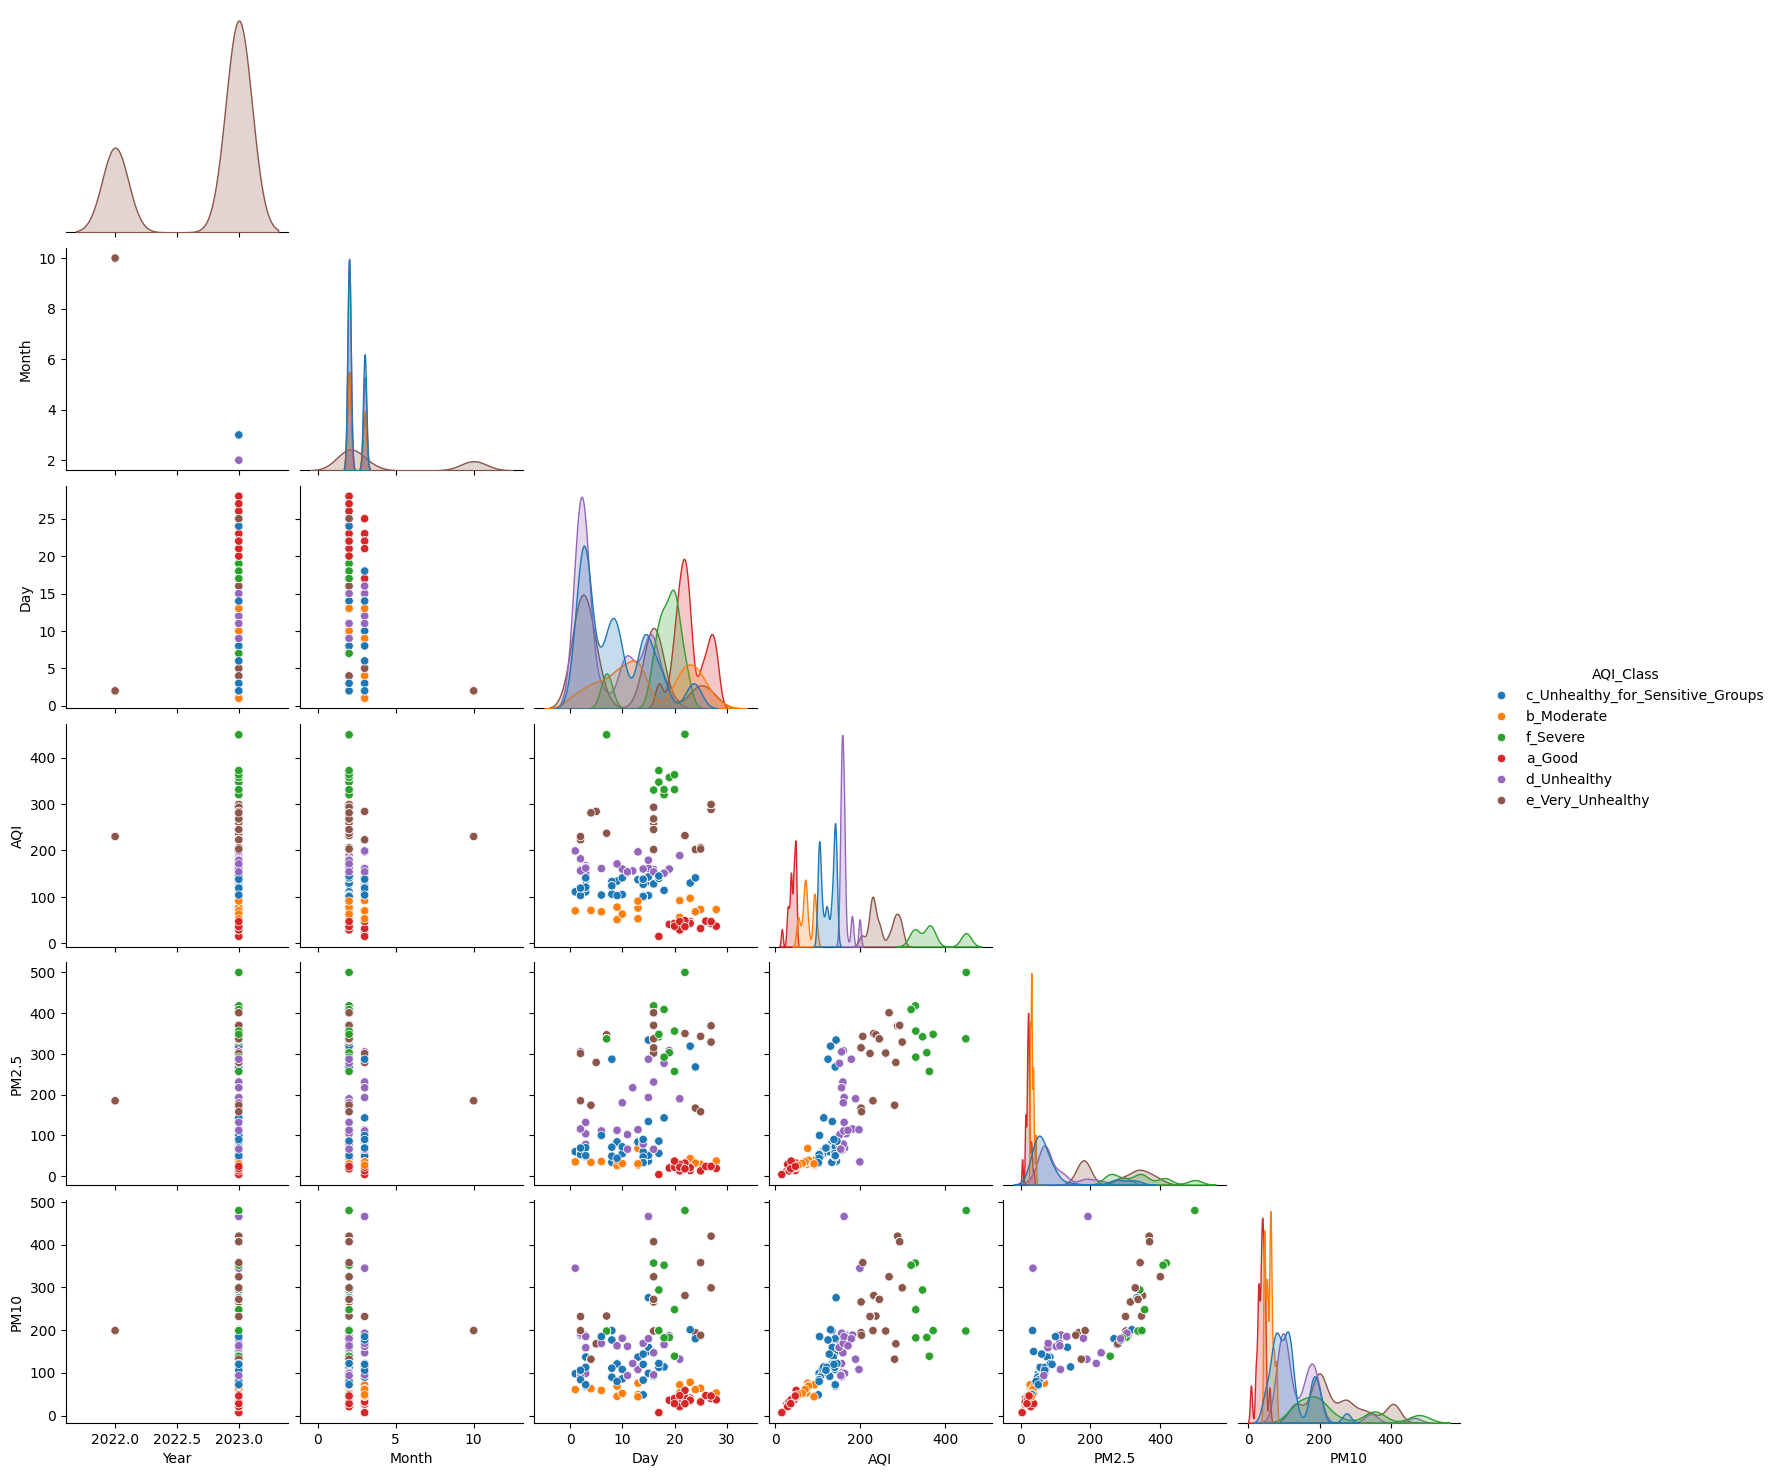

In [13]:
sns.pairplot(train, hue='AQI_Class', diag_kind='kde', corner=True)
plt.show()

In [14]:
def build_x(path):
    train_img = []
    for i in range(train.shape[0]):
        img = image.load_img(path + train['Filename'][i])
        img = image.img_to_array(img)
        img = tf.keras.applications.vgg16.preprocess_input(img)
        #img = img / 255        # with respect to imagenet, no scaling be used
        train_img.append(img)

    x = np.array(train_img)
    return x


x_train = build_x('/content/Air Pollution Image Dataset/Air Pollution Image Dataset/Combined_Dataset/All_img/')

x_train.shape

(7833, 224, 224, 3)

In [15]:
def build_x(path):
    train_img = []
    for i in range(test.shape[0]):
        img = image.load_img(path + test['Filename'][i])
        img = image.img_to_array(img)
        img = tf.keras.applications.vgg16.preprocess_input(img)
        #img = img / 255        # with respect to imagenet, no scaling be used
        train_img.append(img)

    x = np.array(train_img)
    return x


x_test = build_x('/content/Air Pollution Image Dataset/Air Pollution Image Dataset/Combined_Dataset/All_img/')

x_test.shape

(2448, 224, 224, 3)

In [16]:
def build_x(path):
    train_img = []
    for i in range(val.shape[0]):
        img = image.load_img(path + val['Filename'][i])
        img = image.img_to_array(img)
        img = tf.keras.applications.vgg16.preprocess_input(img)
        #img = img / 255        # with respect to imagenet, no scaling be used
        train_img.append(img)

    x = np.array(train_img)
    return x


x_val = build_x('/content/Air Pollution Image Dataset/Air Pollution Image Dataset/Combined_Dataset/All_img/')

x_val.shape

(1959, 224, 224, 3)

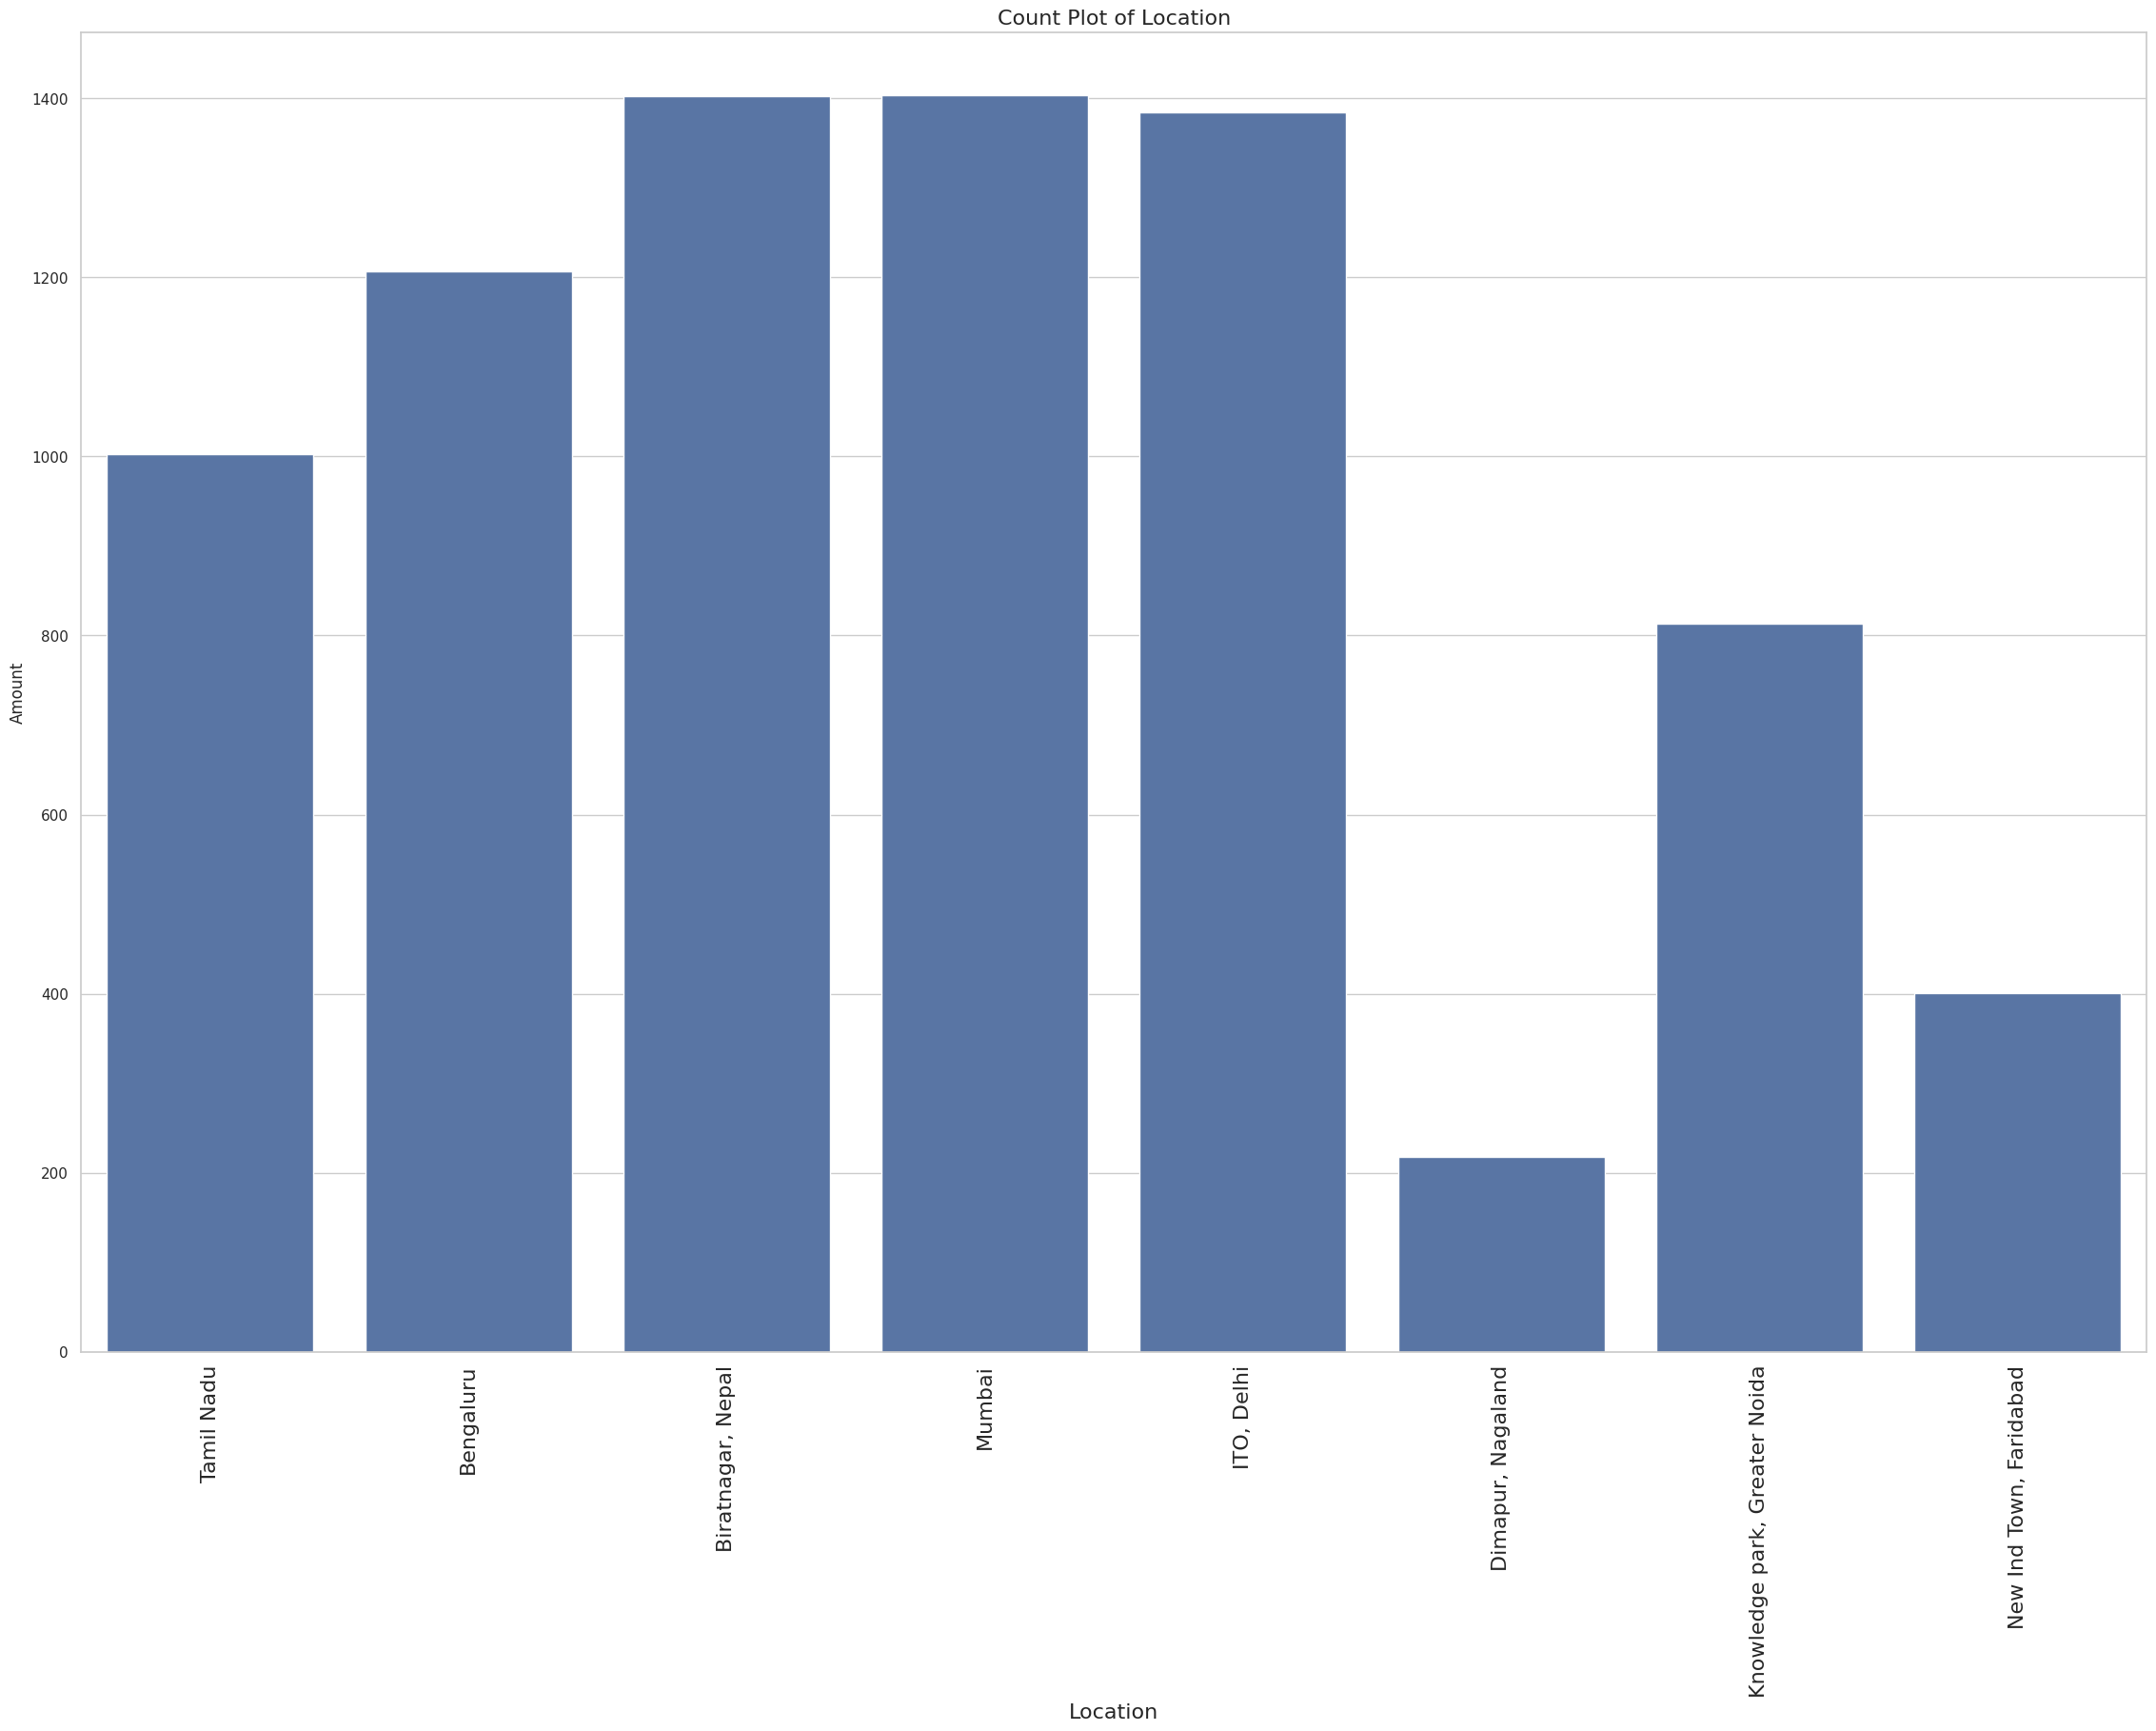

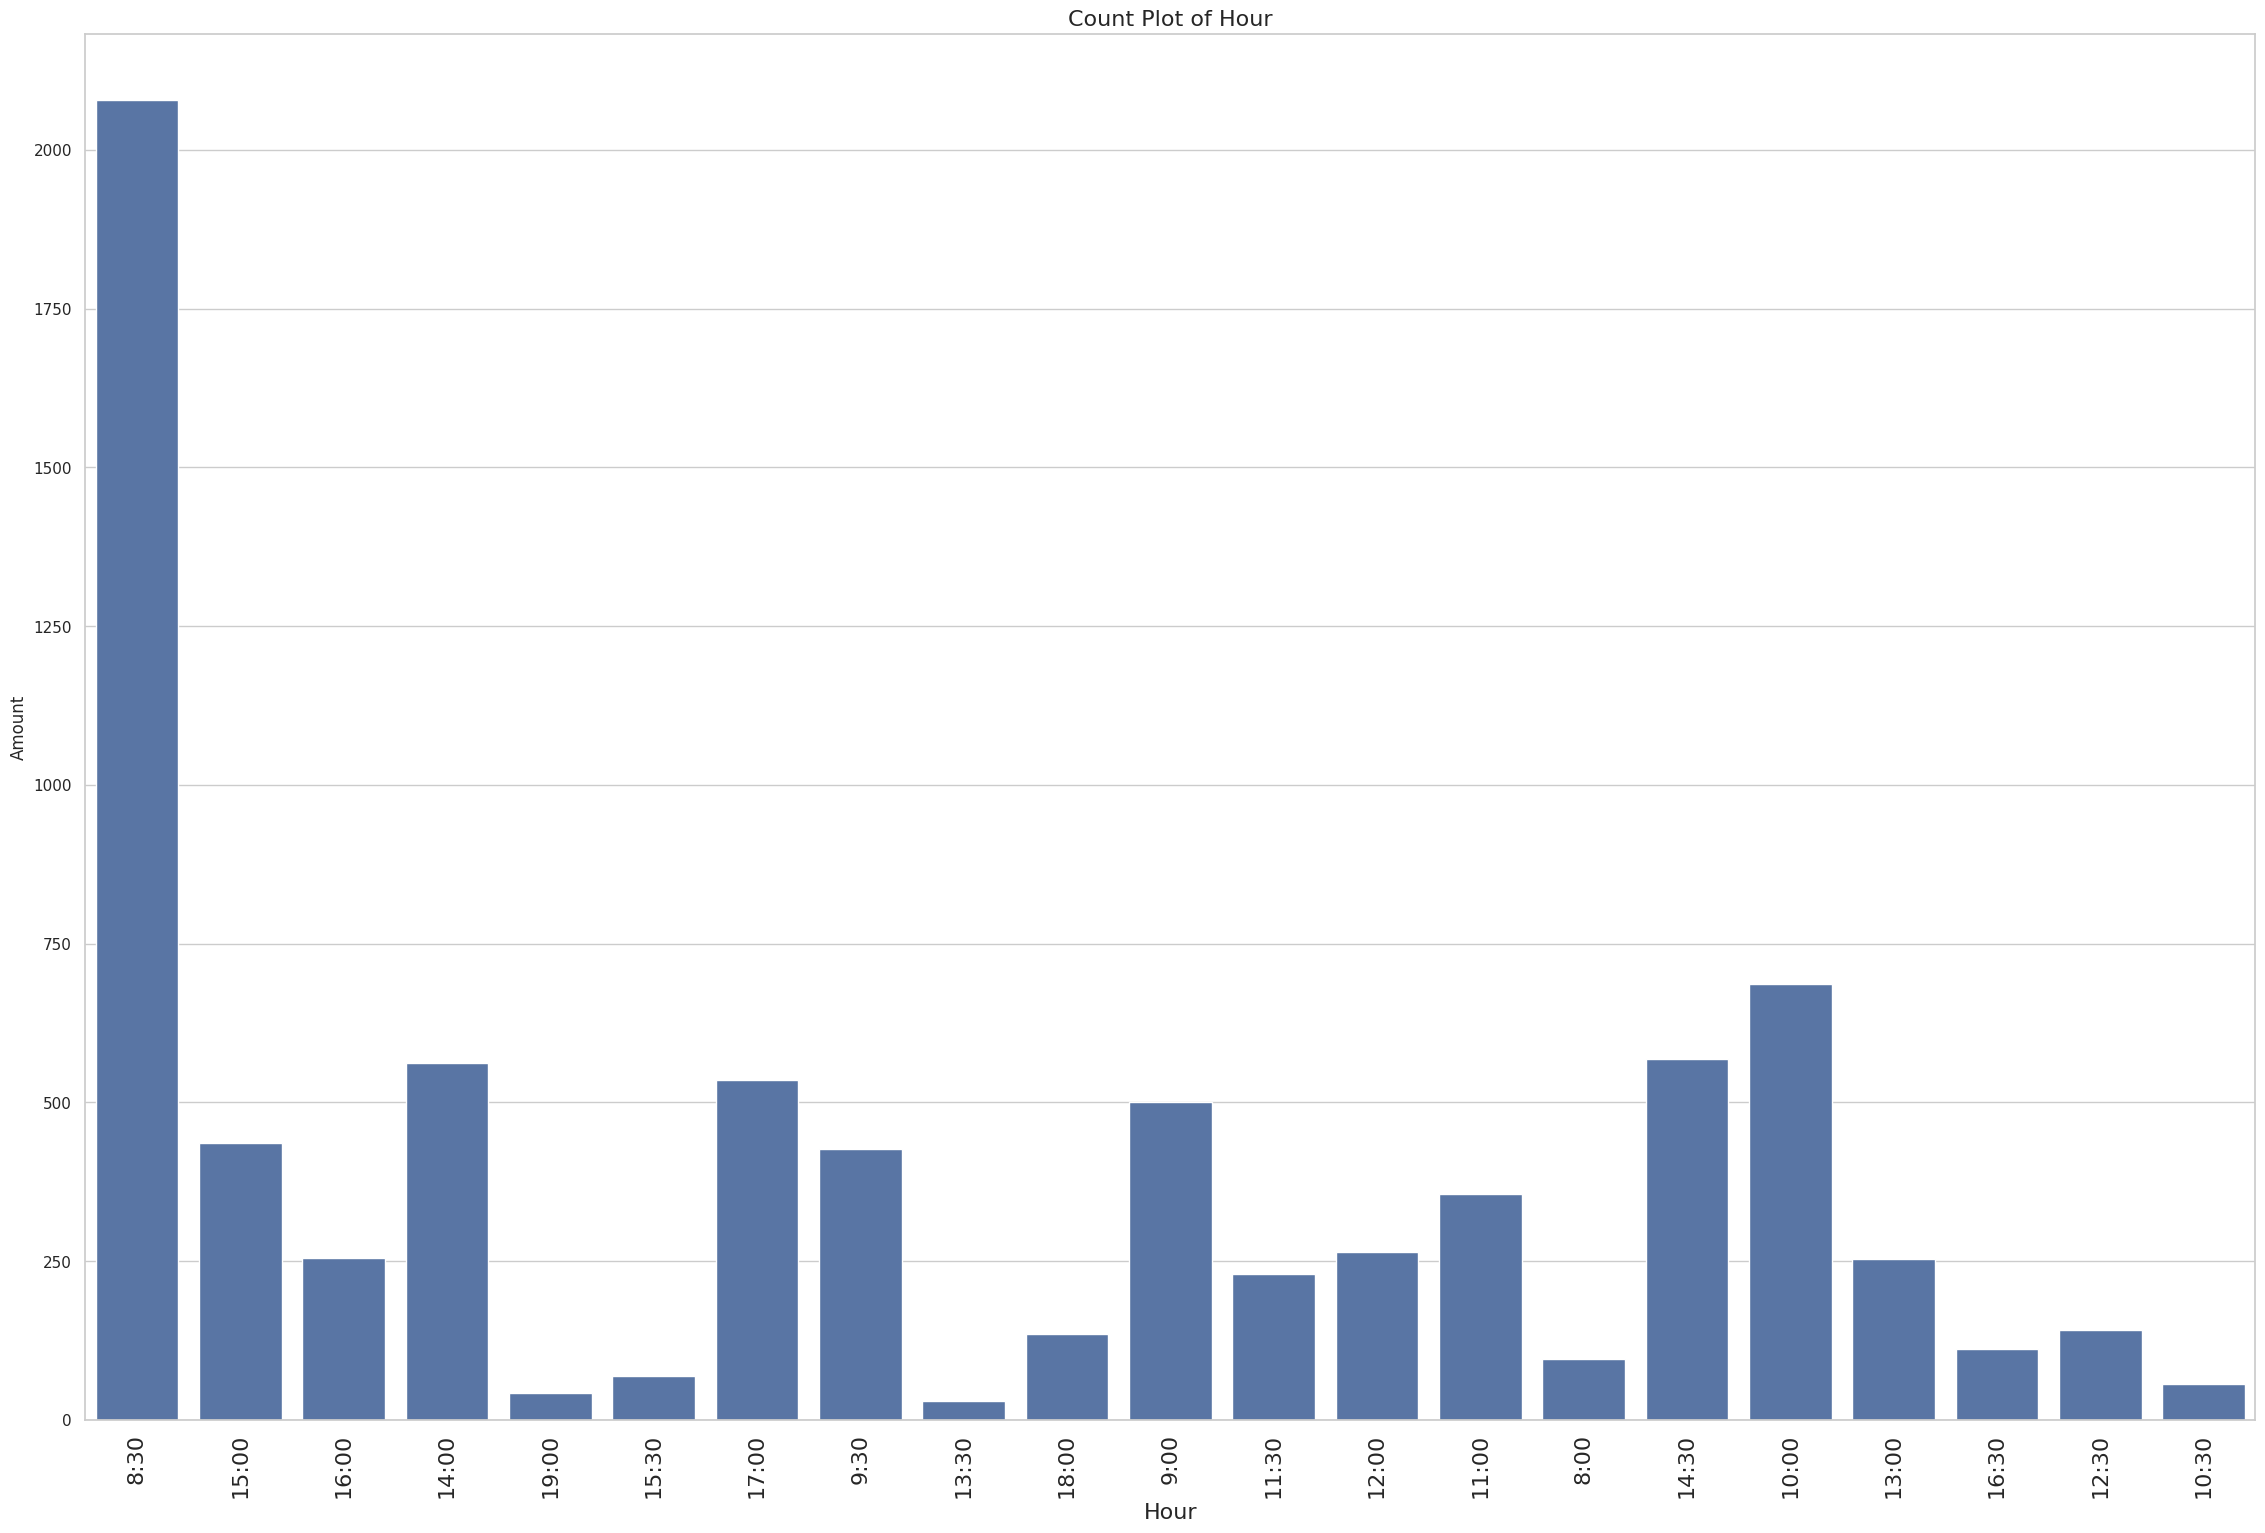

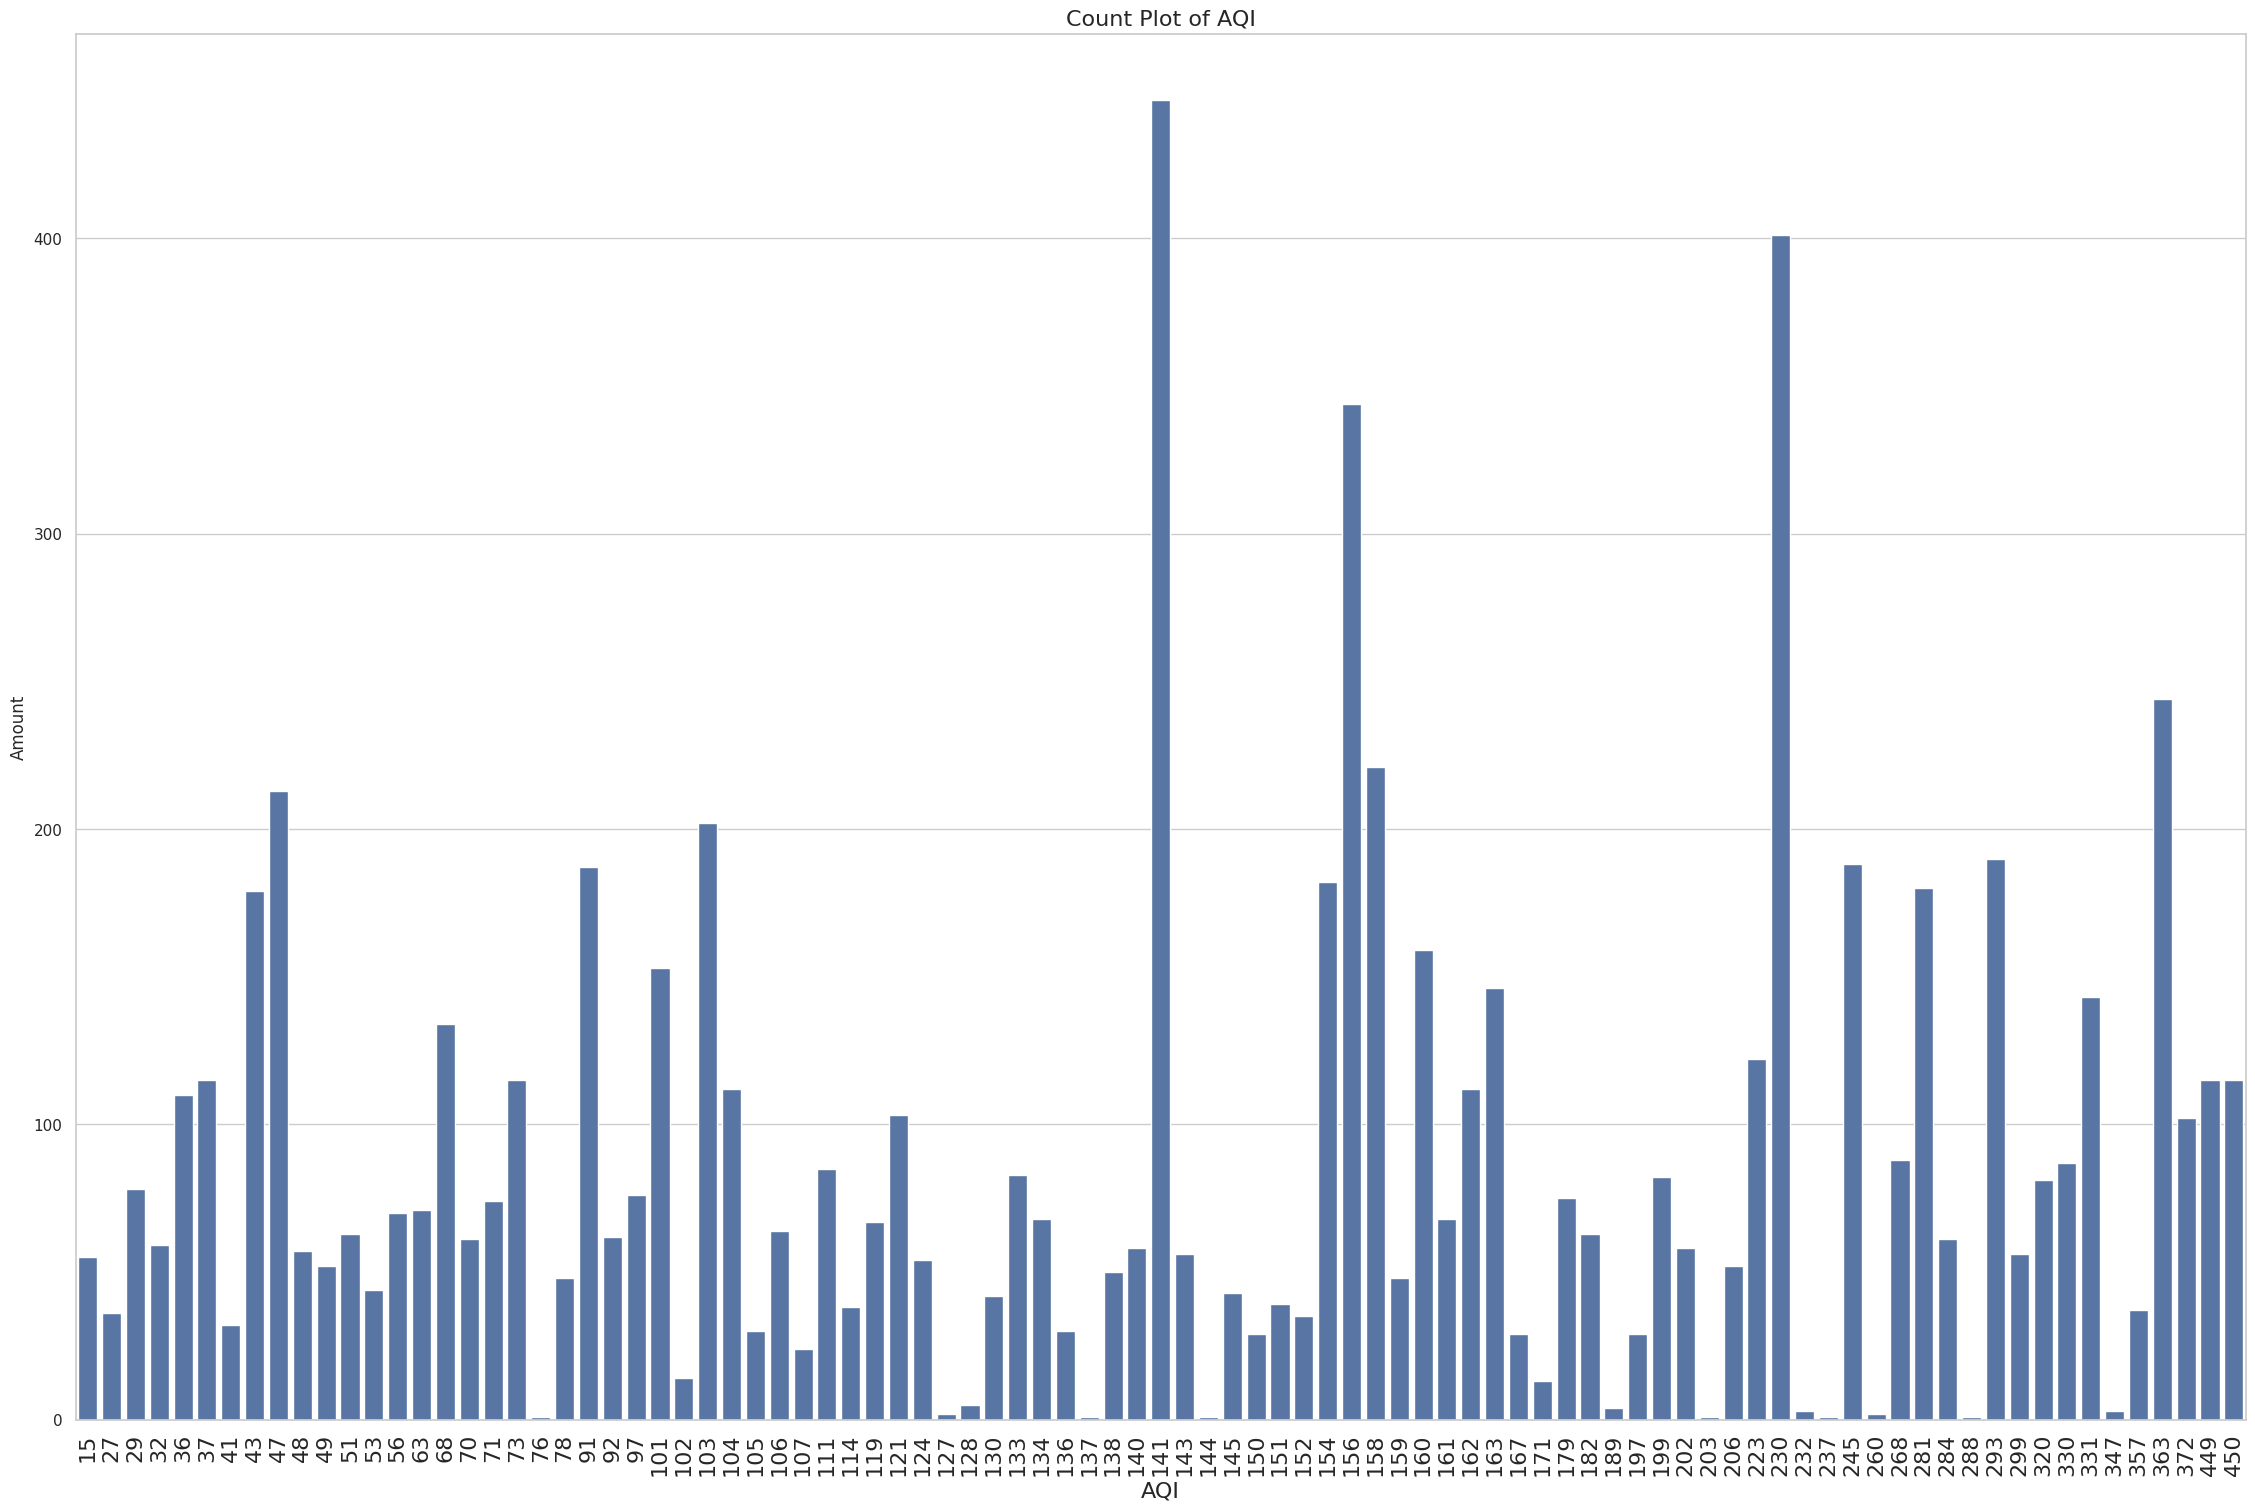

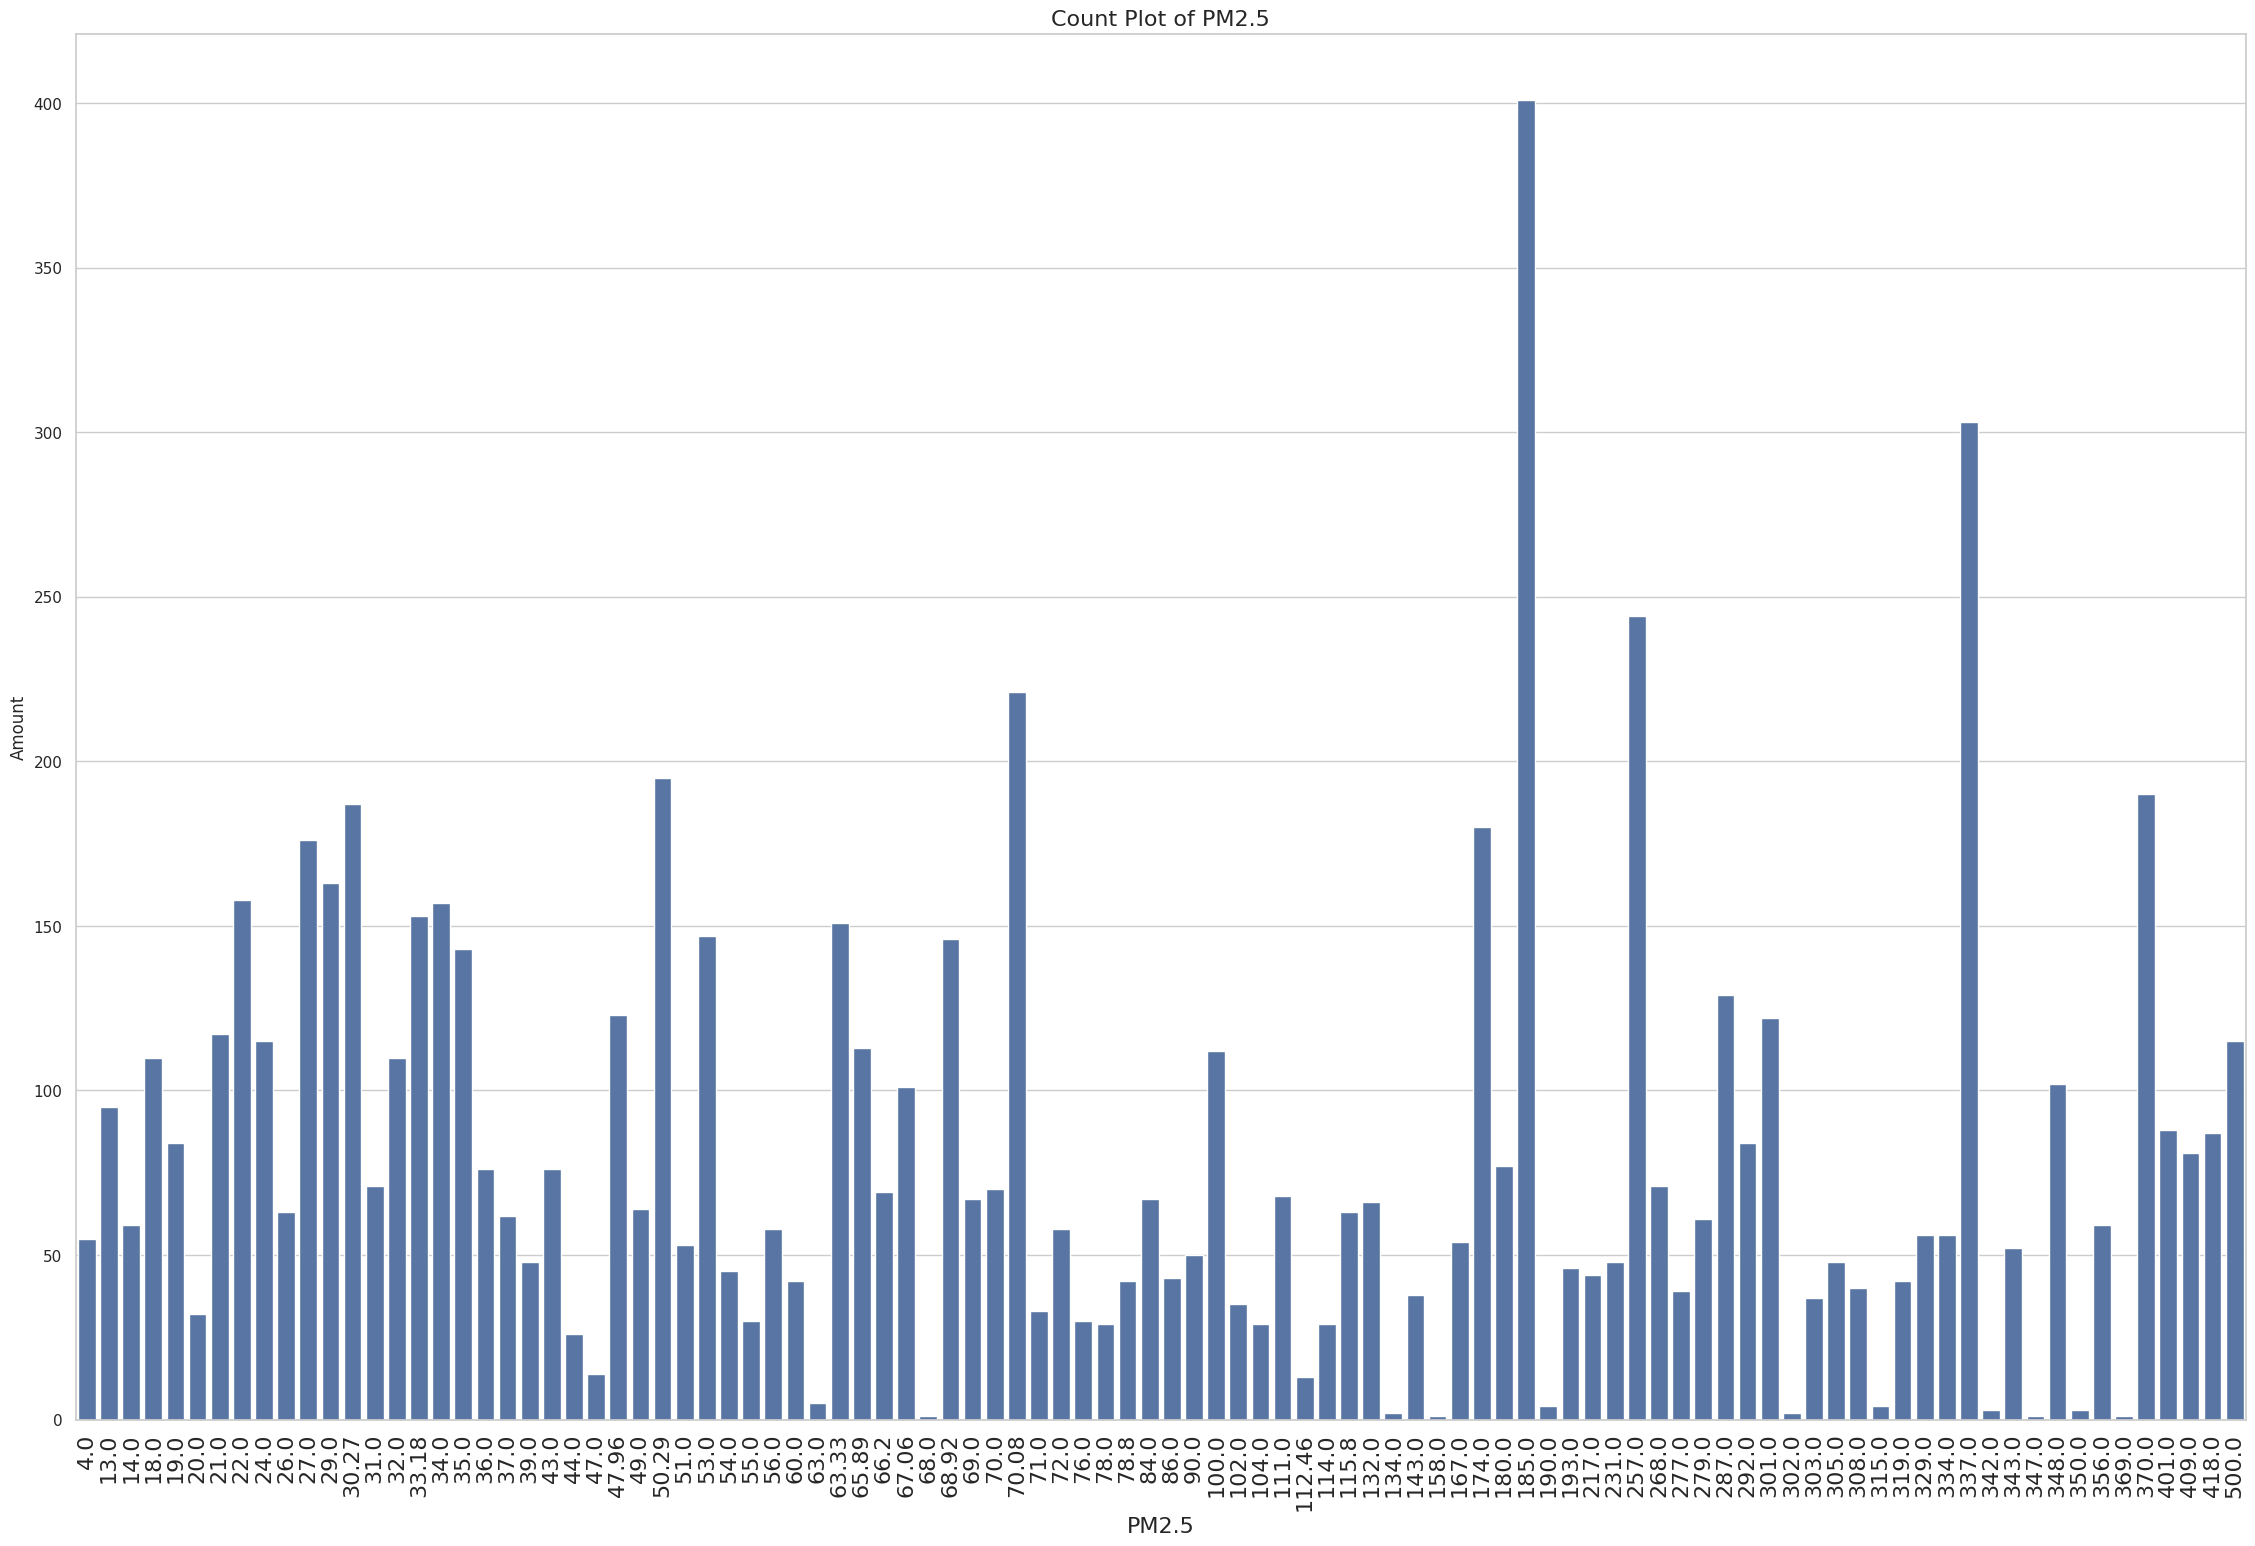

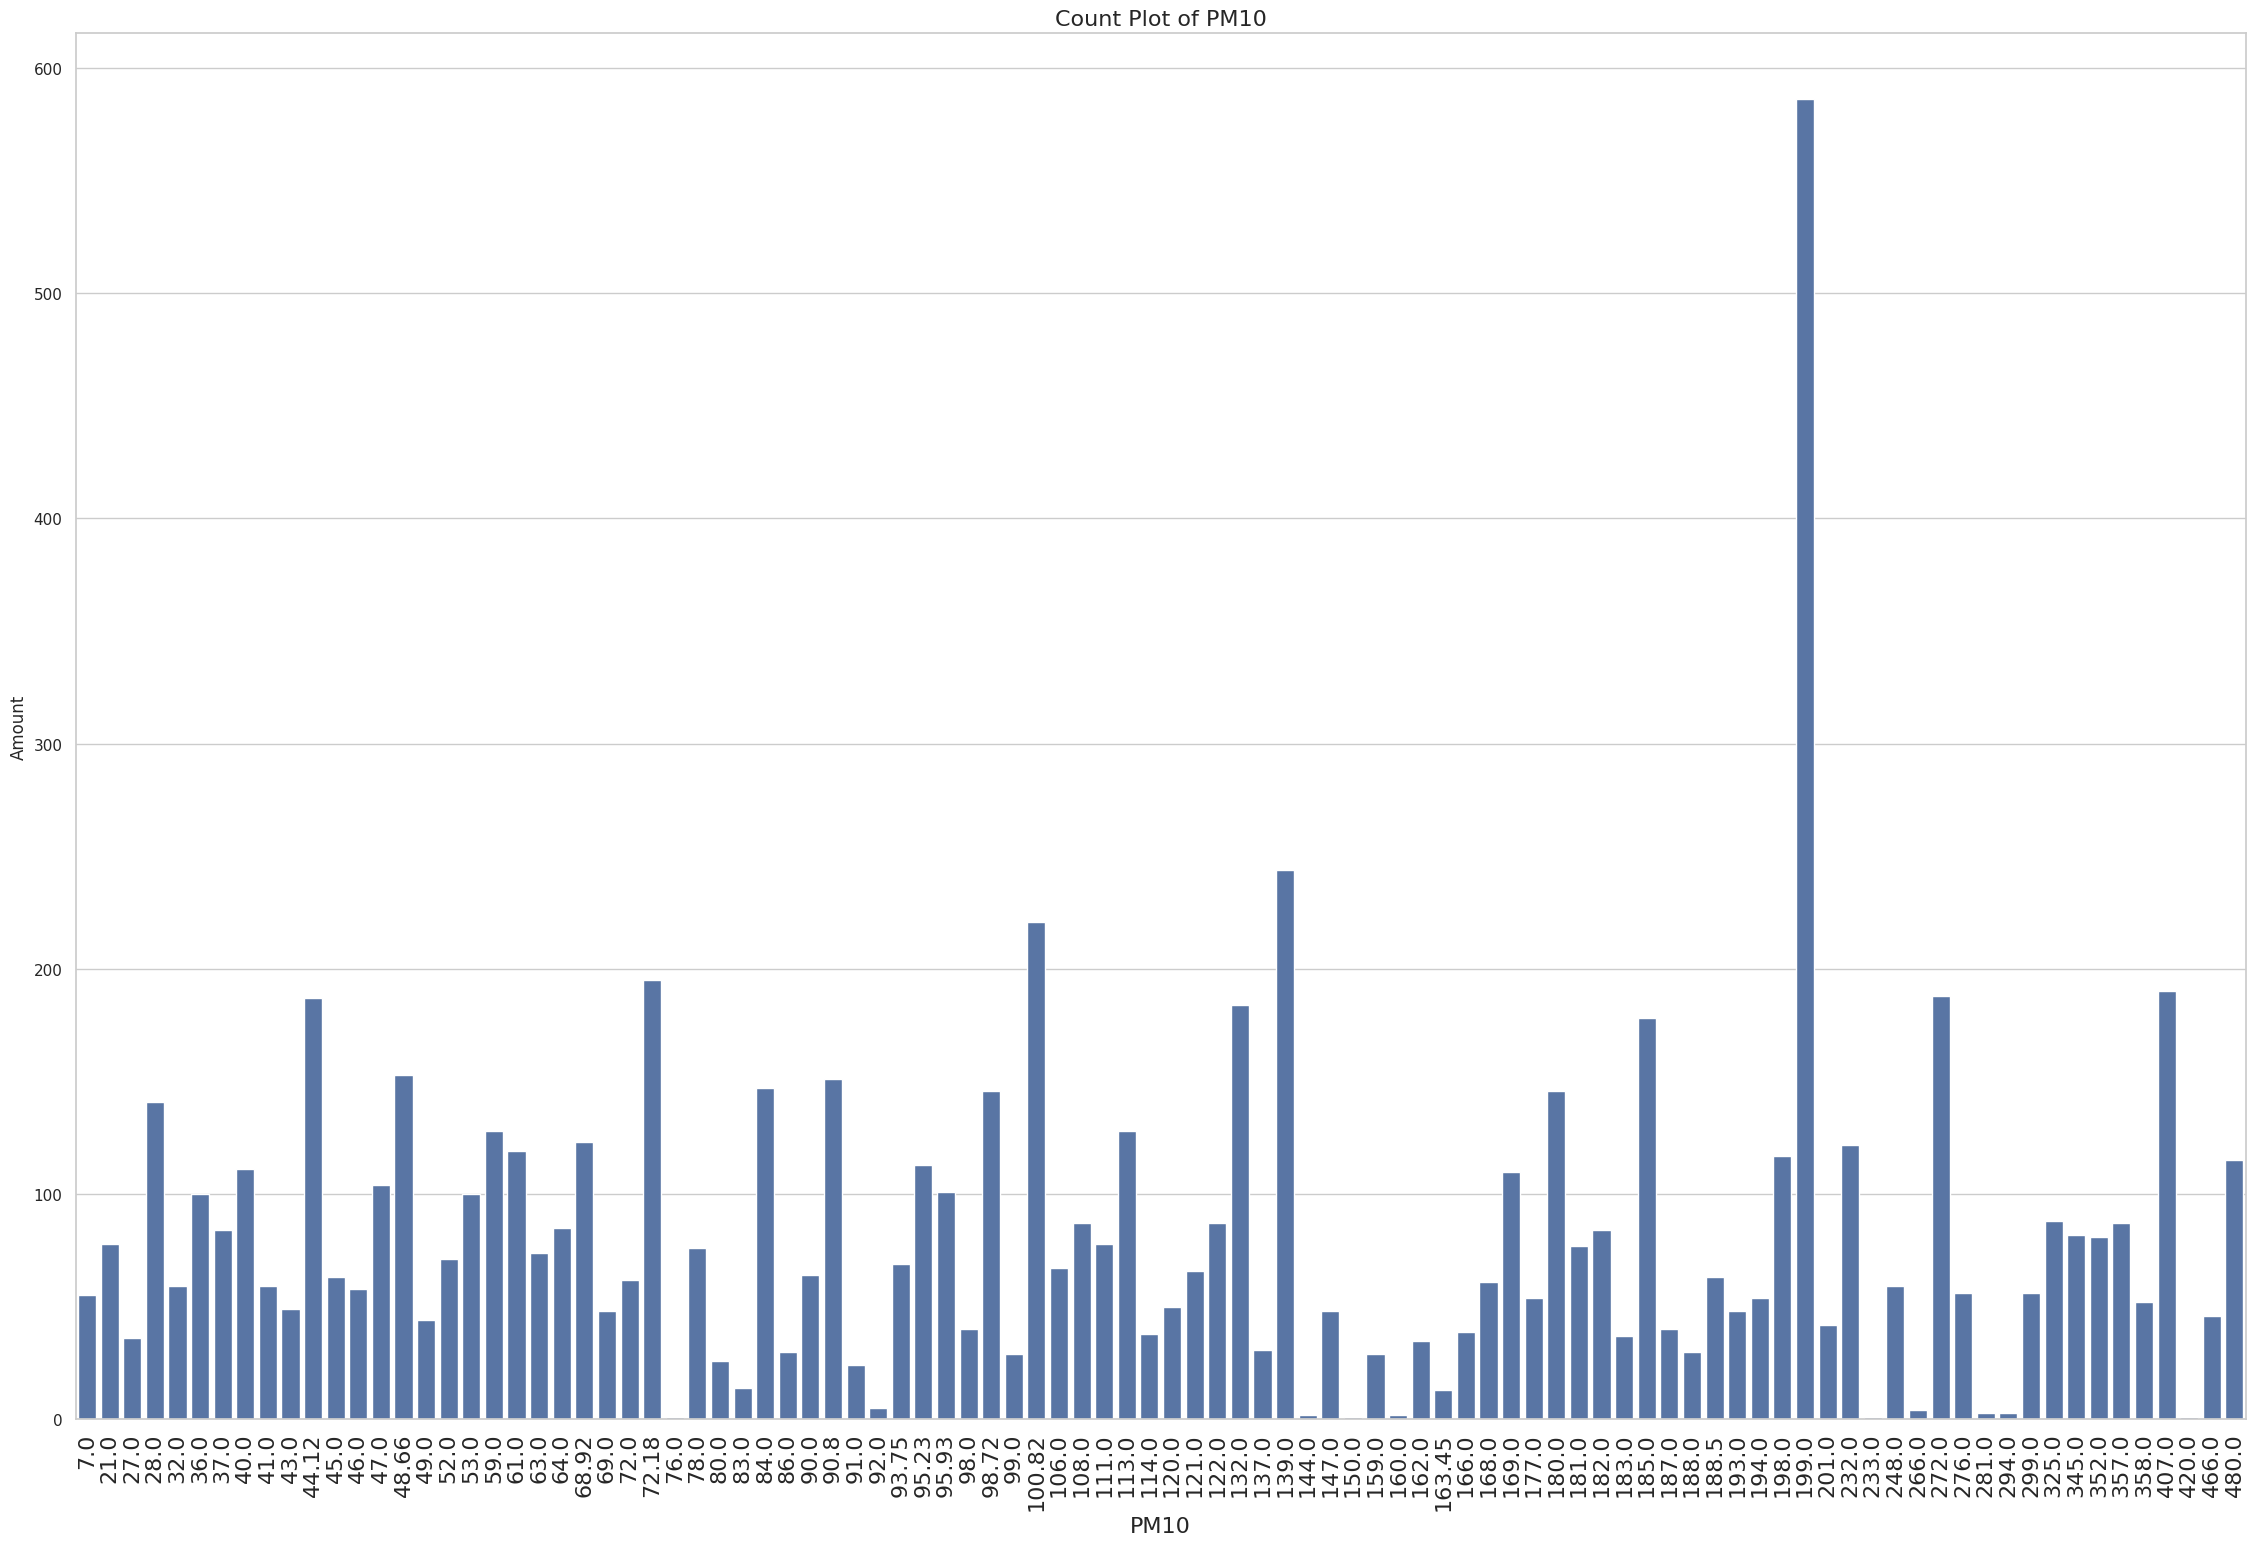

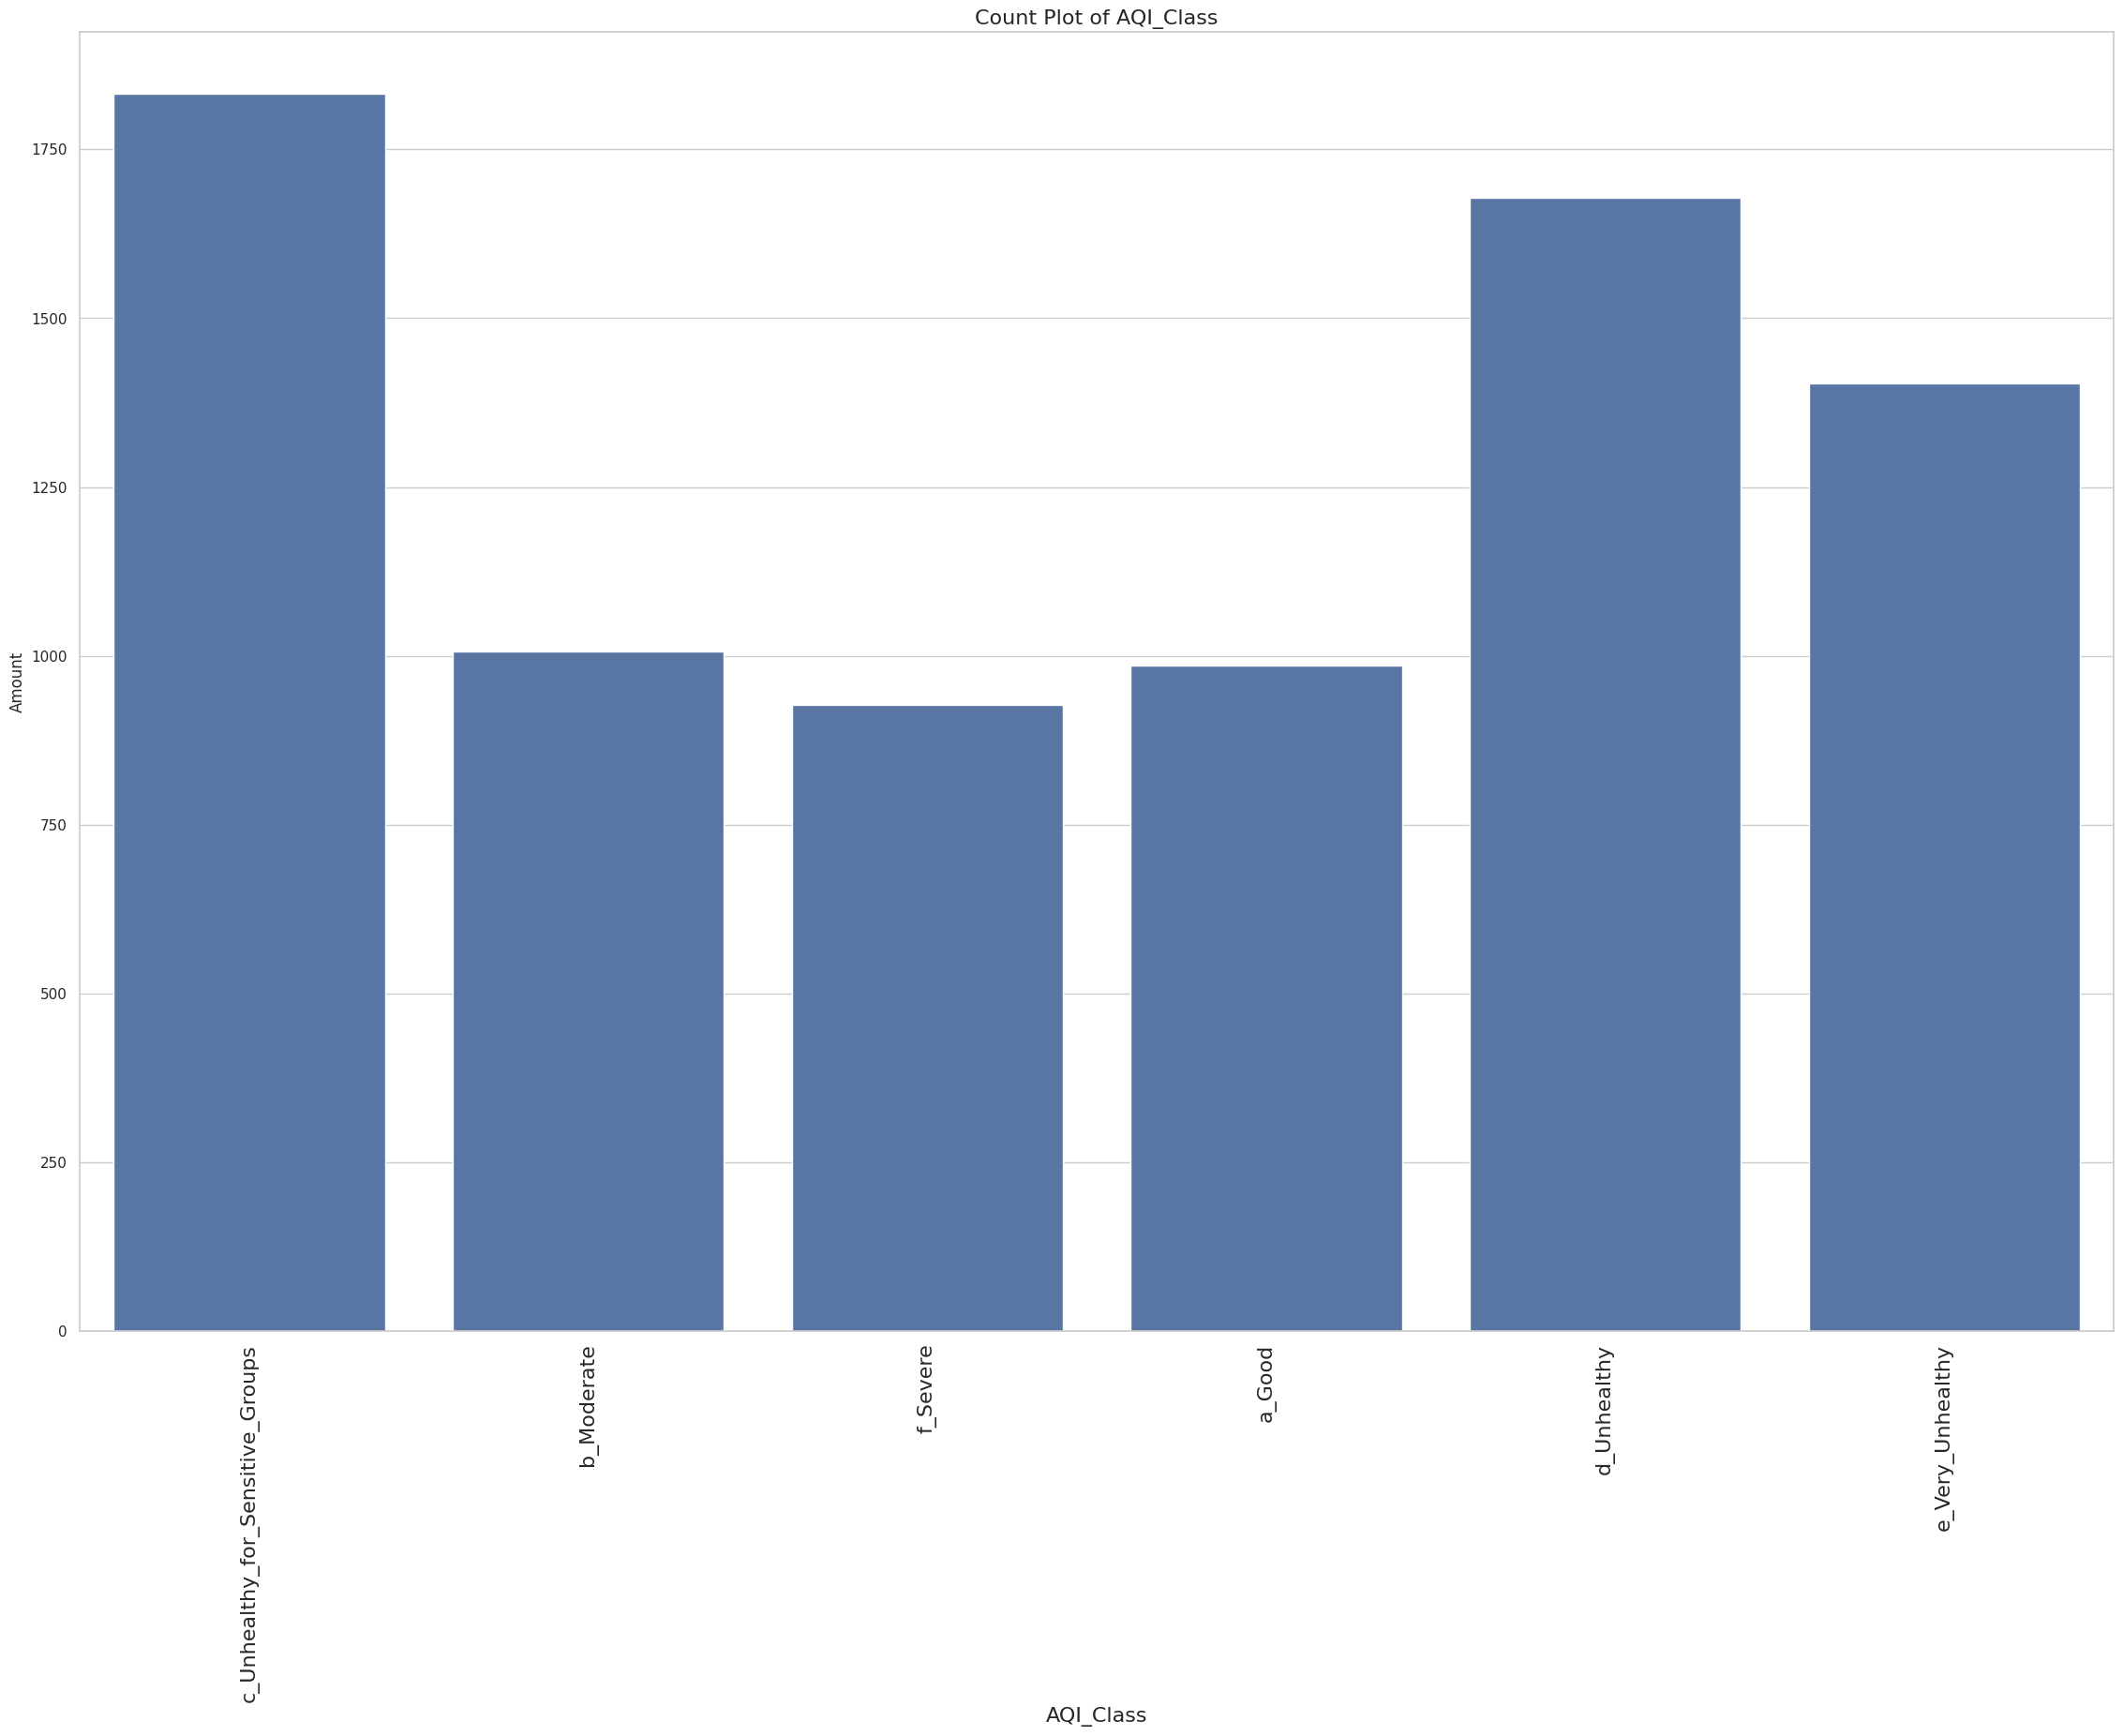

In [17]:
columns = ['Location', 'Hour', 'AQI', 'PM2.5', 'PM10', 'AQI_Class']

sns.set(style="whitegrid")
for column in columns:
    plt.figure(figsize=(28, 18))
    sns.countplot(data=train, x=column)
    plt.title(f'Count Plot of {column}', fontsize=16)
    plt.xlabel(column, fontsize=16)
    plt.ylabel('Amount', fontsize=12)
    plt.xticks(rotation=90,fontsize=16)
    plt.show()

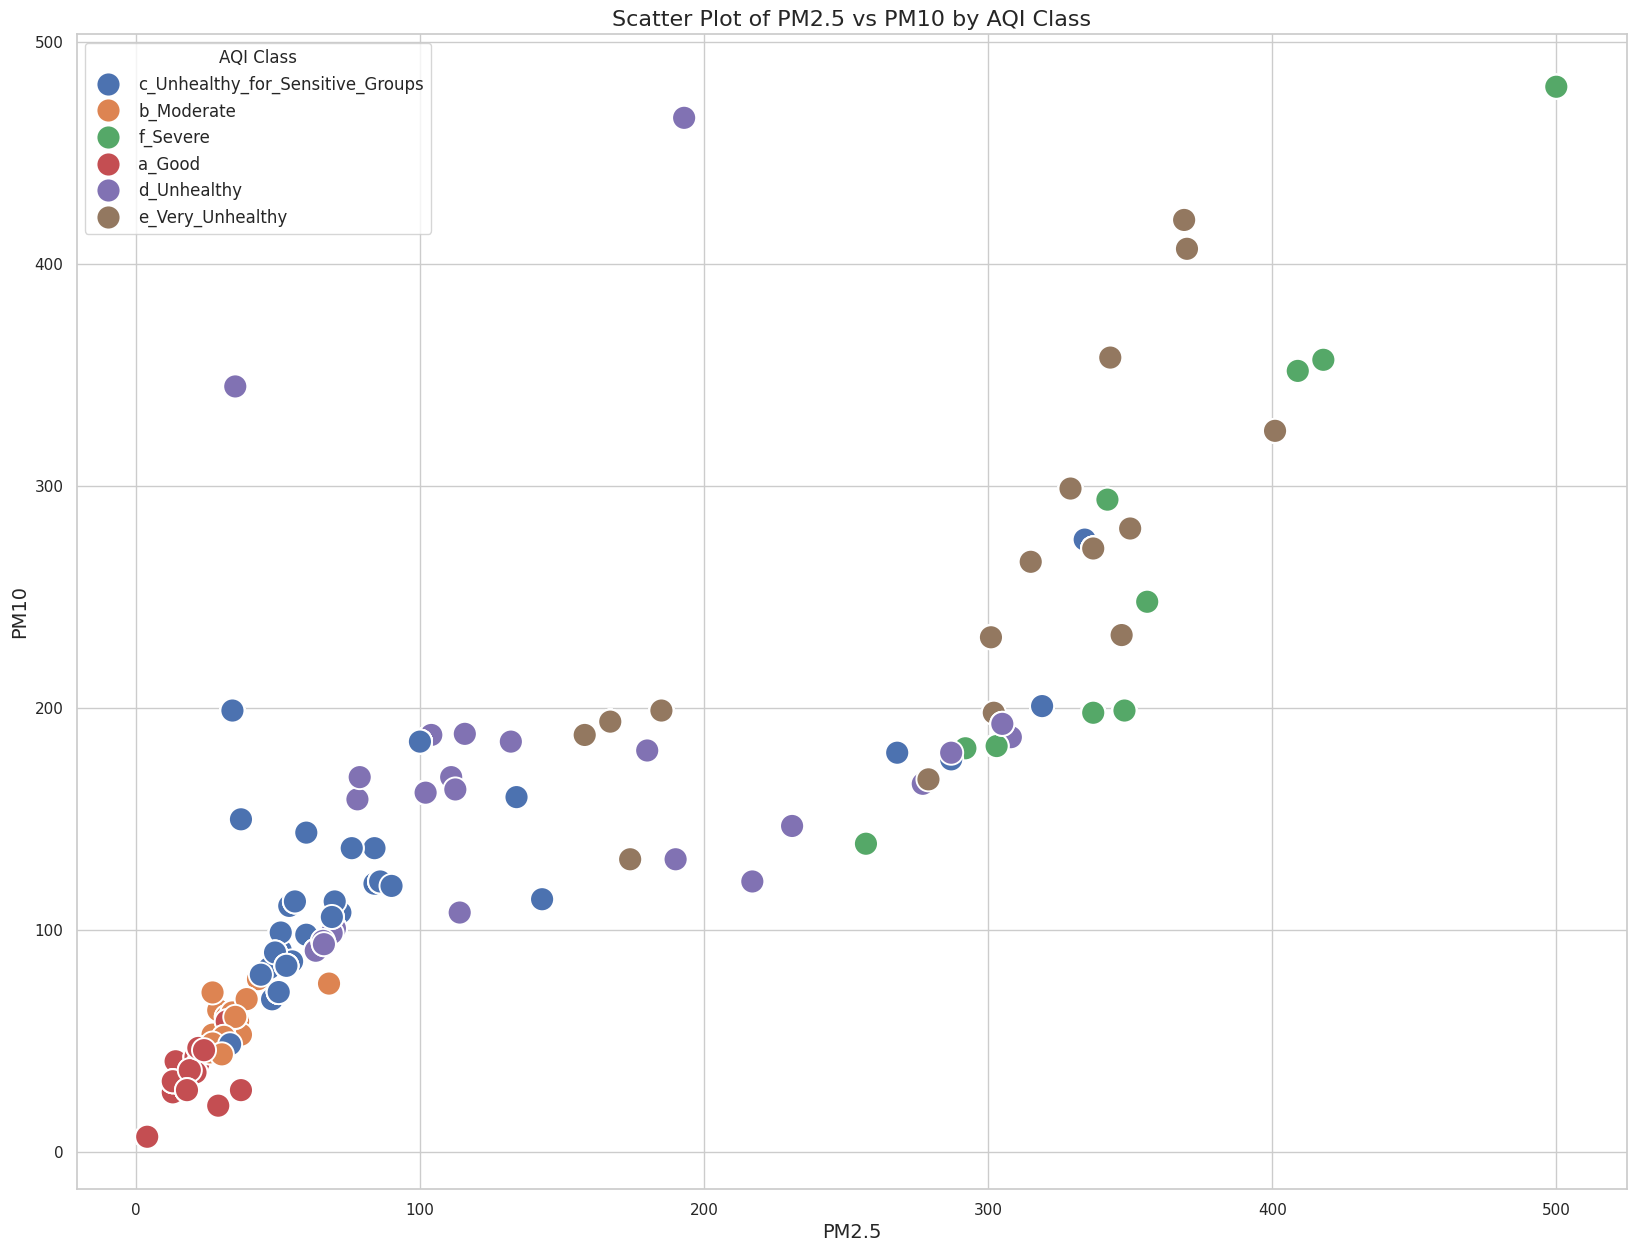

In [18]:
plt.figure(figsize=(20, 15))  # Adjust the figure size as needed
sns.scatterplot(data=train, x='PM2.5', y='PM10', hue='AQI_Class', s=300)
plt.title('Scatter Plot of PM2.5 vs PM10 by AQI Class', fontsize=16)
plt.xlabel('PM2.5', fontsize=14)
plt.ylabel('PM10', fontsize=14)
plt.legend(title='AQI Class', fontsize=12)
plt.show()

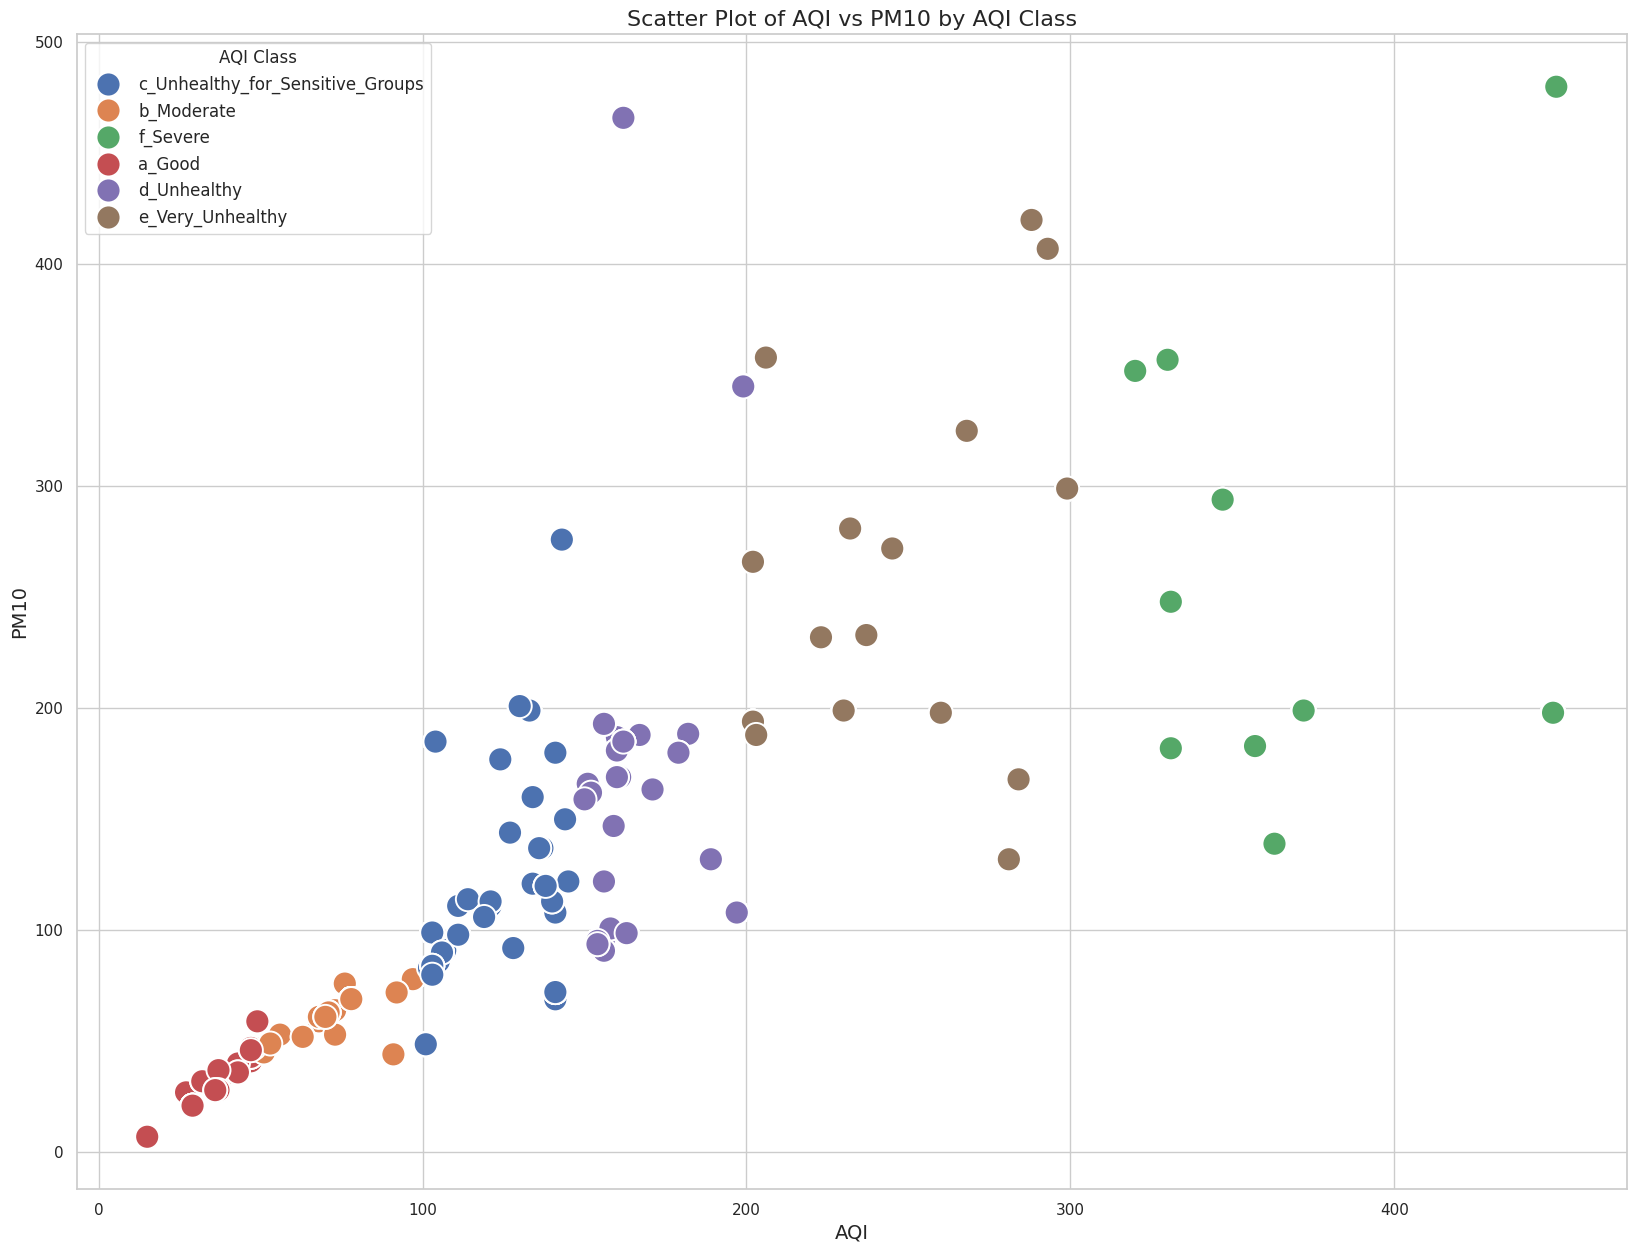

In [19]:
plt.figure(figsize=(20, 15))  # Adjust the figure size as needed
sns.scatterplot(data=train, x='AQI', y='PM10', hue='AQI_Class', s=300)
plt.title('Scatter Plot of AQI vs PM10 by AQI Class', fontsize=16)
plt.xlabel('AQI', fontsize=14)
plt.ylabel('PM10', fontsize=14)
plt.legend(title='AQI Class', fontsize=12)
plt.show()

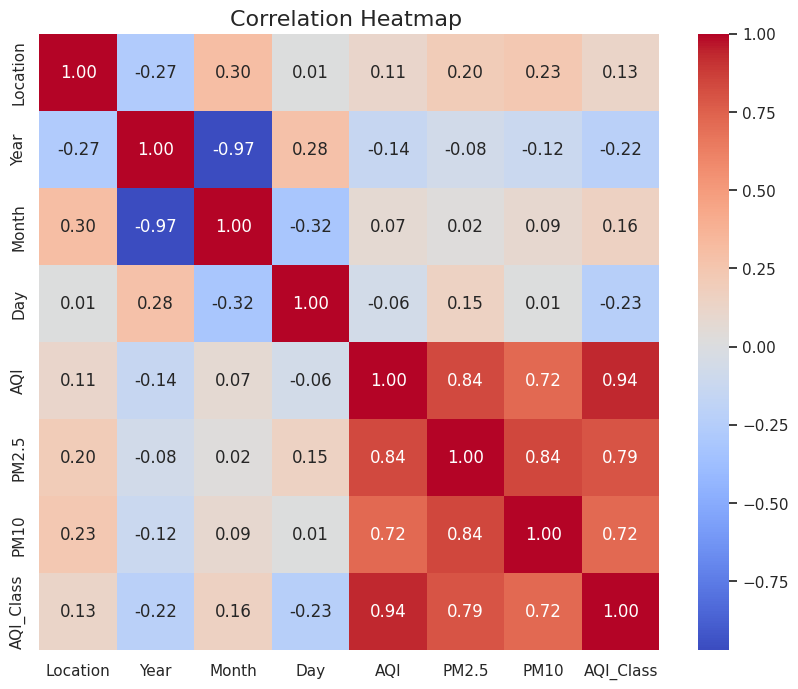

In [20]:
label_encoder = LabelEncoder()
train['Location'] = label_encoder.fit_transform(train['Location'])
train['AQI_Class'] = label_encoder.fit_transform(train['AQI_Class'])

numerical_columns = train.select_dtypes(include=['float64', 'int64'])
plt.figure(figsize=(10, 8))
sns.heatmap(numerical_columns.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap ', fontsize=16)
plt.show()

In [21]:
df_train = train['AQI']

df_train

0       119
1        68
2       141
3       141
4       449
       ... 
7828    171
7829    372
7830    230
7831    138
7832    154
Name: AQI, Length: 7833, dtype: int64

In [22]:
df_test = test['AQI']

df_test

0       158
1       158
2       158
3       158
4       158
       ... 
2443     63
2444     63
2445     63
2446     63
2447     63
Name: AQI, Length: 2448, dtype: int64

In [23]:
df_val = val['AQI']

df_val

0        97
1       450
2       230
3       268
4        47
       ... 
1954    449
1955    363
1956    450
1957    156
1958    162
Name: AQI, Length: 1959, dtype: int64

In [24]:
x_train

array([[[[ 16.060997  ,  -9.778999  , -38.68      ],
         [ 17.060997  ,  -8.778999  , -37.68      ],
         [ 15.060997  ,  -9.778999  , -34.68      ],
         ...,
         [108.061     ,  80.221     ,  54.32      ],
         [110.061     ,  82.221     ,  56.32      ],
         [111.061     ,  83.221     ,  57.32      ]],

        [[ 17.060997  ,  -8.778999  , -37.68      ],
         [ 17.060997  ,  -9.778999  , -35.68      ],
         [ 15.060997  ,  -9.778999  , -34.68      ],
         ...,
         [109.061     ,  81.221     ,  55.32      ],
         [110.061     ,  82.221     ,  56.32      ],
         [111.061     ,  83.221     ,  57.32      ]],

        [[ 17.060997  ,  -9.778999  , -35.68      ],
         [ 17.060997  ,  -9.778999  , -35.68      ],
         [ 16.060997  ,  -8.778999  , -33.68      ],
         ...,
         [110.061     ,  82.221     ,  56.32      ],
         [111.061     ,  83.221     ,  57.32      ],
         [111.061     ,  83.221     ,  57.32      ]],

In [25]:
x_val

array([[[[  31.060997  ,  -36.779     ,  -82.68      ],
         [  31.060997  ,  -36.779     ,  -82.68      ],
         [  32.060997  ,  -35.779     ,  -81.68      ],
         ...,
         [  36.060997  ,  -33.779     ,  -79.68      ],
         [  37.060997  ,  -32.779     ,  -78.68      ],
         [  37.060997  ,  -32.779     ,  -78.68      ]],

        [[  33.060997  ,  -34.779     ,  -80.68      ],
         [  33.060997  ,  -34.779     ,  -80.68      ],
         [  33.060997  ,  -34.779     ,  -80.68      ],
         ...,
         [  37.060997  ,  -32.779     ,  -78.68      ],
         [  37.060997  ,  -32.779     ,  -78.68      ],
         [  38.060997  ,  -31.779     ,  -77.68      ]],

        [[  35.060997  ,  -32.779     ,  -78.68      ],
         [  35.060997  ,  -32.779     ,  -78.68      ],
         [  34.060997  ,  -33.779     ,  -79.68      ],
         ...,
         [  40.060997  ,  -31.779     ,  -77.68      ],
         [  41.060997  ,  -30.779     ,  -76.68      ],
  

In [26]:
x_test

array([[[[ 1.2706100e+02,  1.1222100e+02,  1.0432000e+02],
         [ 1.2706100e+02,  1.1222100e+02,  1.0432000e+02],
         [ 1.2706100e+02,  1.1222100e+02,  1.0432000e+02],
         ...,
         [-3.6939003e+01, -4.0778999e+01, -4.3680000e+01],
         [ 1.3060997e+01,  6.2210007e+00,  4.3199997e+00],
         [-2.4939003e+01, -3.3778999e+01, -3.5680000e+01]],

        [[ 1.2706100e+02,  1.1222100e+02,  1.0432000e+02],
         [ 1.2706100e+02,  1.1222100e+02,  1.0432000e+02],
         [ 1.2706100e+02,  1.1222100e+02,  1.0432000e+02],
         ...,
         [-2.3939003e+01, -2.7778999e+01, -3.0680000e+01],
         [ 4.3060997e+01,  3.6221001e+01,  3.4320000e+01],
         [-4.4939003e+01, -5.3778999e+01, -5.5680000e+01]],

        [[ 1.2706100e+02,  1.1222100e+02,  1.0432000e+02],
         [ 1.2706100e+02,  1.1222100e+02,  1.0432000e+02],
         [ 1.2706100e+02,  1.1222100e+02,  1.0432000e+02],
         ...,
         [ 3.7060997e+01,  3.3221001e+01,  2.9320000e+01],
         [

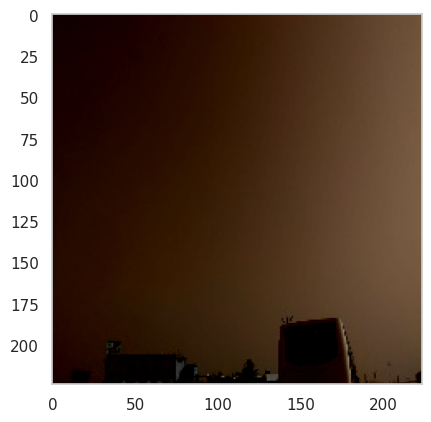

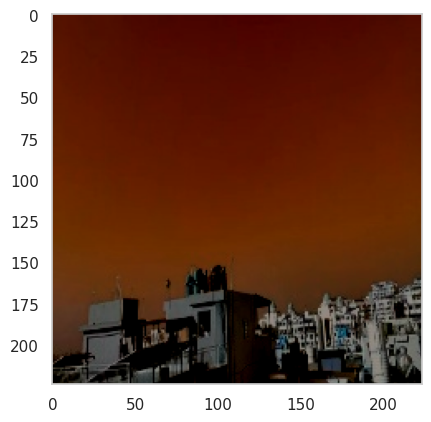

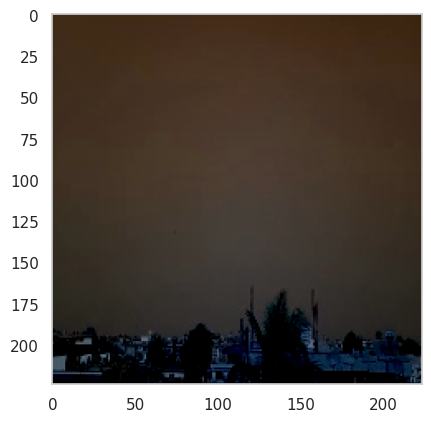

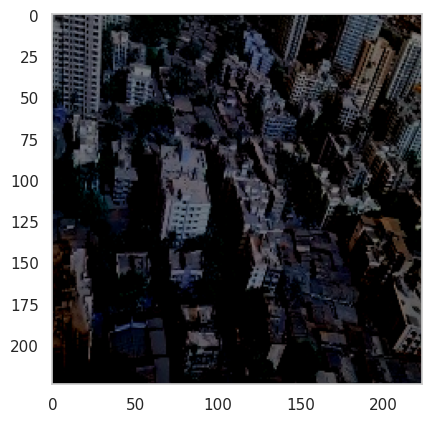

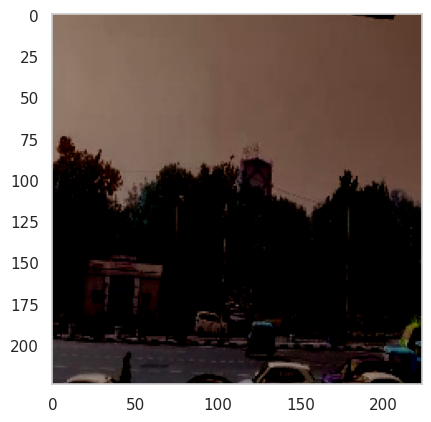

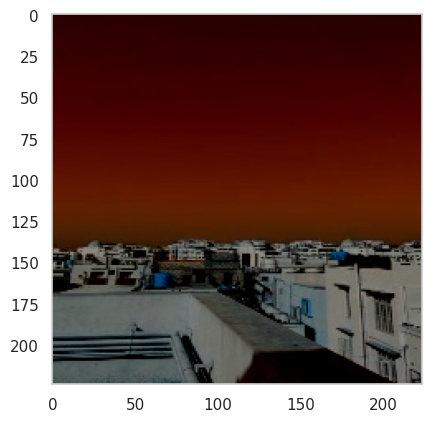

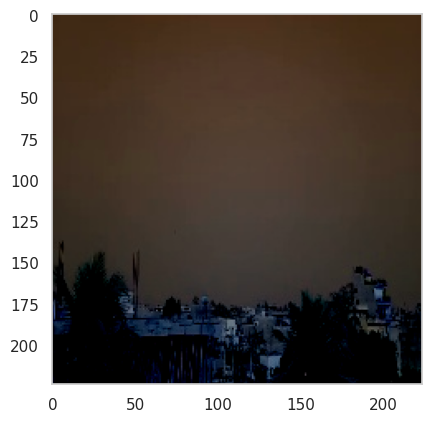

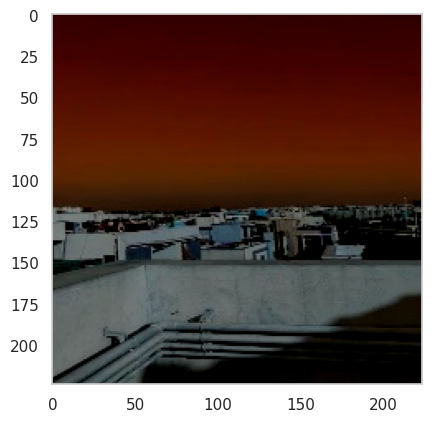

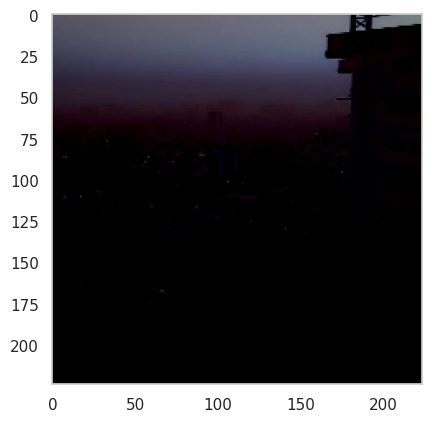

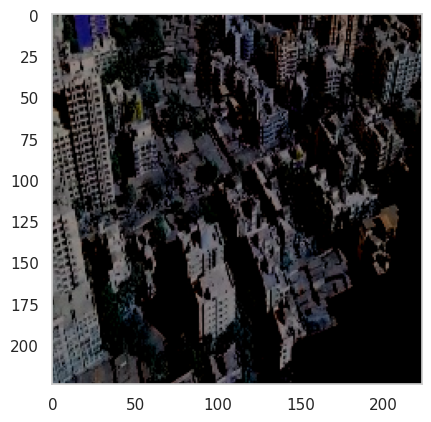

In [27]:
for i in range(0,10):
    plt.imshow(x_train[i] / 255)
    plt.grid(False)
    plt.show()

# nn


In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split


x_origin_train, x_origin_temp, y_train, y_temp = train_test_split(x_train[:1000], df_train[:1000], train_size=0.7)

# Ensure input data has the correct shape by removing the extra dimension
x_origin_train = x_origin_train.reshape(-1, 224, 224, 3)
x_origin_temp = x_origin_temp.reshape(-1, 224, 224, 3)

# Define the neural network model
NN_model = Sequential()

# The Input Layer:
# Assuming your input shape is (224, 224, 3)
NN_model.add(Dense(512, kernel_initializer='normal', activation='relu', input_shape=(224, 224, 3)))

# The Hidden Layers:
NN_model.add(Dense(256, kernel_initializer='normal', activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal', activation='relu'))

# The Output Layer:
NN_model.add(Dense(1, kernel_initializer='normal', activation='linear'))

# Compile the network:
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
NN_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 224, 224, 512)     2048      
                                                                 
 dense_15 (Dense)            (None, 224, 224, 256)     131328    
                                                                 
 dense_16 (Dense)            (None, 224, 224, 256)     65792     
                                                                 
 dense_17 (Dense)            (None, 224, 224, 1)       257       
                                                                 
Total params: 199425 (779.00 KB)
Trainable params: 199425 (779.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Fitting the ANN to the Training set
model_history = NN_model.fit(x_origin_train, y_train, validation_data=(x_origin_temp, y_temp), batch_size=16, epochs=10)

# **InceptionV3**

In [29]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

In [30]:
model=load_model('/content/model_inception.h5')

In [31]:
# Here we will be using imagenet weights

inception = InceptionV3(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

In [32]:
# don't train existing weights
for layer in inception.layers:
    layer.trainable = False

In [33]:

# Flatten the output of the InceptionV3 model
x1 = Flatten()(inception.output)

# Add fully connected layers
fc1 = Dense(512, activation='relu')(x1)
fc2 = Dense(512, activation='relu')(fc1)

# Output layer
output_layer = Dense(1, activation='sigmoid')(fc2)

# Combine the base model with fully connected layers
model = Model(inception.input, output_layer)

# Compile the model
model.compile(loss='mse', optimizer='adam')

# Display model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 111, 111, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 111, 111, 32)         0         ['batch_normalization[0][0

In [34]:
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [ ]:
from sklearn.model_selection import train_test_split

# Splitting the data into training and validation sets
x_origin_train, x_origin_temp, y_train, y_temp = train_test_split(x_train[:1000], df_train[:1000], train_size=0.7)

# Training the model
history = model.fit(
    x=x_origin_train,
    y=y_train,
    validation_data=(x_origin_temp, y_temp),
    batch_size=16,
    epochs=5
)


# **VGG16**

In [ ]:
vgg16_model  = tf.keras.applications.VGG16(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
for layer in vgg16_model.layers:
    layer.trainable = False
    print(layer.name)

In [ ]:
x1 = Flatten()(vgg16_model.output)
fc1 = Dense(512, activation = 'relu')(x1)
fc2 = Dense(512, activation = 'relu')(fc1)
x = Dense(1, activation='sigmoid')(fc2)
model = Model(vgg16_model.input, x)

model.compile(loss='mse', optimizer='adam')
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
from google.colab import files

weight_path = "{}_aqi.best.weights.h5".format('vgg16')
# Saving the file
with open(weight_path, 'w') as f:
    f.write('content_of_the_file')

# Downloading the file
files.download(weight_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
x_train1=x_train[:500]
df_train1=df_train[:500]

In [ ]:
x_train

array([[[[ 16.060997  ,  -9.778999  , -38.68      ],
         [ 17.060997  ,  -8.778999  , -37.68      ],
         [ 15.060997  ,  -9.778999  , -34.68      ],
         ...,
         [108.061     ,  80.221     ,  54.32      ],
         [110.061     ,  82.221     ,  56.32      ],
         [111.061     ,  83.221     ,  57.32      ]],

        [[ 17.060997  ,  -8.778999  , -37.68      ],
         [ 17.060997  ,  -9.778999  , -35.68      ],
         [ 15.060997  ,  -9.778999  , -34.68      ],
         ...,
         [109.061     ,  81.221     ,  55.32      ],
         [110.061     ,  82.221     ,  56.32      ],
         [111.061     ,  83.221     ,  57.32      ]],

        [[ 17.060997  ,  -9.778999  , -35.68      ],
         [ 17.060997  ,  -9.778999  , -35.68      ],
         [ 16.060997  ,  -8.778999  , -33.68      ],
         ...,
         [110.061     ,  82.221     ,  56.32      ],
         [111.061     ,  83.221     ,  57.32      ],
         [111.061     ,  83.221     ,  57.32      ]],

In [34]:
callback = [    EarlyStopping(monitor='val_loss', patience=15, verbose=1, mode='auto'),
                ModelCheckpoint(weight_path, monitor='val_loss', verbose=1,
                save_best_only=True, mode='min', save_weights_only = True)]

x_origin_train, x_origin_temp, y_train, y_temp = train_test_split(x_train1, df_train1, train_size=0.7)
history = model.fit(x=x_origin_train, y=y_train, validation_data=(x_origin_temp, y_temp), batch_size=16, epochs=100 , callbacks=callback)

Epoch 1/100
22/22 [==============================] - ETA: 0s - loss: 38486.3594
Epoch 1: val_loss improved from inf to 44052.81250, saving model to vgg16_aqi.best.weights.h5
22/22 [==============================] - 201s 9s/step - loss: 38486.3594 - val_loss: 44052.8125
Epoch 2/100
22/22 [==============================] - ETA: 0s - loss: 38482.4922
Epoch 2: val_loss did not improve from 44052.81250
22/22 [==============================] - 192s 9s/step - loss: 38482.4922 - val_loss: 44052.8125
Epoch 3/100
22/22 [==============================] - ETA: 0s - loss: 38482.4922
Epoch 3: val_loss did not improve from 44052.81250
22/22 [==============================] - 195s 9s/step - loss: 38482.4922 - val_loss: 44052.8125
Epoch 4/100
22/22 [==============================] - ETA: 0s - loss: 38482.4922
Epoch 4: val_loss did not improve from 44052.81250
22/22 [==============================] - 217s 10s/step - loss: 38482.4922 - val_loss: 44052.8125
Epoch 5/100
22/22 [=============================